In [30]:
%load_ext autoreload
%autoreload 2

from collections import OrderedDict
import cv2
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from skimage.transform import resize
from skimage.color import rgb2gray

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.config import CfgNode as CN
from detectron2.data import (
    MetadataCatalog,
    build_detection_test_loader,
    build_detection_train_loader,
)
from detectron2.data.datasets import load_coco_json
from detectron2.engine import DefaultTrainer, DefaultPredictor, default_argument_parser, default_setup, launch
from detectron2.evaluation import inference_on_dataset, COCOEvaluator
from detectron2.modeling import build_model
from detectron2.utils.events import EventStorage
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

import scene_generation.inverse_graphics.synthetic_scene_database_loader as loader
from scene_generation.inverse_graphics.synthetic_scene_database_loader import XenRCNNMapper
import scene_generation.inverse_graphics.keypoint_mcmc.roi_heads as roi_heads

np.set_printoptions(precision=2)

DATA_ROOT = "/home/gizatt/data/generated_cardboard_envs/"
DETECTRON_ROOT = "/home/gizatt/tools/detectron2/"

%matplotlib inline
def cv2_imshow(im):
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    plt.axis('off')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [31]:
from detectron2.data import DatasetCatalog, MetadataCatalog
from scene_generation.inverse_graphics.synthetic_scene_database_loader import load_xencoco_json

DatasetCatalog.clear()
def load_dataset(d):
    return load_xencoco_json(
        os.path.join(DATA_ROOT, "%s.json" % (d)),
        data_root=DATA_ROOT,
        dataset_name="synthetic_%s" % d)
def load_real_dataset():
    return load_coco_json(
        "/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json",
        image_root="/home/gizatt/data/coco/cardboard_boxes_in_wild/images",
        dataset_name="prime_boxes_real", extra_annotation_keys=None)
for d in ["train", "test"]:
    DatasetCatalog.register("synthetic_" + d, lambda d=d: load_dataset(d))
DatasetCatalog.register("prime_boxes_real", load_real_dataset)
synthetic_train_metadata = MetadataCatalog.get("synthetic_train")
real_prime_boxes_metadata = MetadataCatalog.get("prime_boxes_real")
real_prime_boxes_metadata.set(json_file="/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json")
print("Metadata train: ", synthetic_train_metadata)
print("Metadata real: ", real_prime_boxes_metadata)
DatasetCatalog.register("synthetic_5_types", lambda: load_dataset("scene_groups_5_types"))

Metadata train:  Metadata(name='synthetic_train', thing_classes=['prime_box'], thing_dataset_id_to_contiguous_id={1: 0})
Metadata real:  Metadata(json_file='/home/gizatt/data/coco/cardboard_boxes_in_wild/coco.json', name='prime_boxes_real')


In [27]:
cfg = get_cfg()
cfg.merge_from_file(os.path.join(DETECTRON_ROOT, "configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))

cfg.INPUT.MIN_SIZE_TRAIN = (480)
cfg.INPUT.MIN_SIZE_TEST = (480)
cfg.INPUT.DEPTH_FORMAT = 'L'
cfg.DATALOADER.ASPECT_RATIO_GROUPING = False

cfg.DATASETS.TRAIN = ("synthetic_train",)
cfg.DATASETS.TEST = ("synthetic_test",)
cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.META_ARCHITECTURE = "GeneralizedRCNN"

#cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
# Start from pre-trained on just detections
base_weight_dir = "notebooks/output/keypoint_cmcm/maskrcnn_base_without_heatmap_padded_boxes_1/"
cfg.MODEL.WEIGHTS = os.path.join(base_weight_dir, "model_final.pth")

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # default
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # only has one class (prime box)
cfg.MODEL.ROI_HEADS.NAME = "KeypointMCMCROIHeads"
cfg.MODEL.ROI_HEADS.HEATMAP_LOSS_WEIGHT = 1

cfg.MODEL.ROI_HEATMAP_HEAD = CN()
cfg.MODEL.ROI_HEATMAP_HEAD.NAME = "RCNNHeatmapHead"
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_RESOLUTION = 14
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_SAMPLING_RATIO = 2
cfg.MODEL.ROI_HEATMAP_HEAD.POOLER_TYPE = "ROIAlign"
cfg.MODEL.ROI_HEATMAP_HEAD.NUM_KEYPOINT_TYPES = 2
cfg.MODEL.ROI_HEATMAP_HEAD.NUM_CONV = 4
cfg.MODEL.ROI_HEATMAP_HEAD.CONV_CHANNELS = [512, 512, 512, 512]
cfg.MODEL.ROI_HEATMAP_HEAD.CONV_SIZES = [3, 3, 3, 3]
cfg.MODEL.ROI_HEATMAP_HEAD.WITH_DECONV = True
cfg.MODEL.ROI_HEATMAP_HEAD.WITH_2X_UPSCALE = False
cfg.MODEL.ROI_HEATMAP_HEAD.NORM = ""
cfg.MODEL.ROI_HEATMAP_HEAD.TARGET_HEATMAP_SIZE = 28


test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))

[06/19 11:49:34 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(480, 480), max_size=1333, sample_style='choice'), RandomFlip()]


NameError: name 'detectron2' is not defined

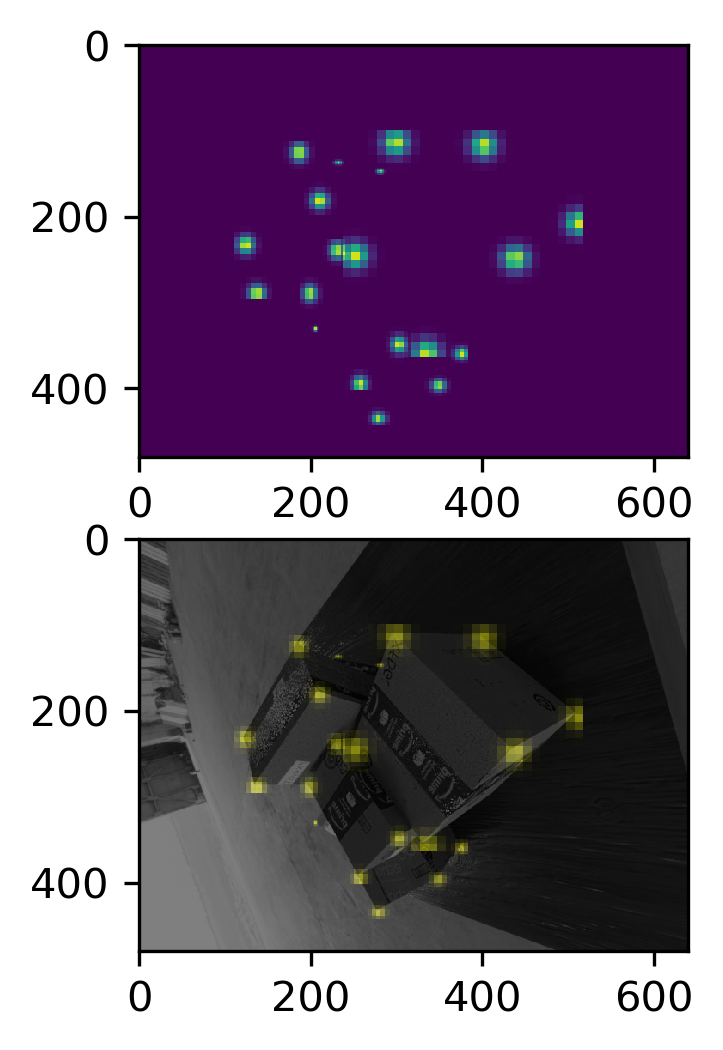

In [4]:
out = iter(test_loader).next()[0]

def combine_gt_instance_keypoints_to_image(instances, image_size, ind):
    heatmap = torch.zeros(image_size)
    for k in range(len(instances)):
        for batch_k in range(instances[k].gt_heatmaps.shape[0]):
            local_heatmap = instances[k].gt_heatmaps[batch_k, ind, ...]
            box = instances[k].gt_boxes[batch_k].tensor.flatten().int()
            width = box[2] - box[0]
            height = box[3] - box[1]
            scaled_heatmap = F.interpolate(local_heatmap.unsqueeze(0).unsqueeze(0), (height, width))
            heatmap[box[1]:box[3], box[0]:box[2]] += scaled_heatmap[0, 0, ...]
    return heatmap

plt.figure(dpi=300).set_size_inches(4, 4)
orig_image_gray = rgb2gray(out["image"].permute(1, 2, 0))/255.
total_heatmap = combine_gt_instance_keypoints_to_image(out["instances"], orig_image_gray.shape, 0)

plt.subplot(2, 1, 1)
plt.imshow(total_heatmap)

total_heatmap = resize(total_heatmap.detach().cpu().numpy(), orig_image_gray.shape)
total_heatmap /= np.max(total_heatmap)

plt.subplot(2, 1, 2)
plt.imshow(np.stack([orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5], axis=-1))

In [5]:
model = build_model(cfg)
model.eval()

/home/gizatt/miniconda3/envs/py36_pyro/lib/python3.6/site-packages/torch/cuda/__init__.py:134: UserWarning: 
    Found GPU1 GeForce GTX 680 which is of cuda capability 3.0.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability that we support is 3.5.
    
  warnings.warn(old_gpu_warn % (d, name, major, capability[1]))


GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): Sequential(
        (0): BottleneckBlock

In [ ]:
class Trainer(DefaultTrainer):

    @classmethod
    def build_test_loader(cls, cfg, dataset_name):
        return build_detection_test_loader(cfg, dataset_name, mapper=XenRCNNMapper(cfg, False))

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=XenRCNNMapper(cfg, True))

    @classmethod
    def build_evaluator(cls, cfg, dataset_name):
        return COCOEvaluator(dataset_name, cfg, True, output_dir=cfg.OUTPUT_DIR)
            
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.01
cfg.SOLVER.MAX_ITER = 100000     # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.OUTPUT_DIR = "notebooks/output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax/"
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = Trainer(cfg)
# Freeze everything but the 
to_freeze = [trainer.model.backbone,
             trainer.model.proposal_generator,
             trainer.model.roi_heads.box_pooler,
             trainer.model.roi_heads.box_head,
             trainer.model.roi_heads.box_predictor,
             trainer.model.roi_heads.mask_pooler,
             trainer.model.roi_heads.mask_head]

for module in to_freeze:
    for param in module.parameters():
        param.requires_grad = False

trainer.resume_or_load(resume=True)
trainer.train()

[06/18 00:21:43 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

[06/18 00:21:43 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(480, 480), max_size=1333, sample_style='choice'), RandomFlip()]
[06/18 00:21:44 d2.data.build]: Removed 0 images with no usable annotations. 1000 images left.
[06/18 00:21:44 d2.data.common]: Serializing 1000 elements to byte tensors and concatenating them all ...
[06/18 00:21:44 d2.data.common]: Serialized dataset takes 62.35 MiB
[06/18 00:21:44 d2.data.build]: Using training sampler TrainingSampler
[06/18 00:21:45 d2.engine.train_loop]: Starting training from iteration 1000
Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.4840e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5685, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0582, device='cuda:0', grad_fn=<MaxBackward1

Heatmap loss:  tensor(0.0674, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0878e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4362, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0674, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0674, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:21:56 d2.utils.events]:  eta: 1:25:23  iter: 1019  total_loss: 0.310  loss_cls: 0.041  loss_box_reg: 0.103  loss_mask: 0.082  loss_keypoint_heatmap: 0.065  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.5822  data_time: 0.0175  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0556, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8404e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4886, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0556, device='c

Heatmap loss:  tensor(0.0584, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0449e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5848, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0584, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0584, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:22:08 d2.utils.events]:  eta: 1:25:11  iter: 1039  total_loss: 0.297  loss_cls: 0.042  loss_box_reg: 0.095  loss_mask: 0.084  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.5758  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0624, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3590e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4912, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0624, device='c

Heatmap loss:  tensor(0.0616, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0385e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4791, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0616, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0616, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:22:20 d2.utils.events]:  eta: 1:25:06  iter: 1059  total_loss: 0.311  loss_cls: 0.045  loss_box_reg: 0.106  loss_mask: 0.091  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.5798  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0649, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9392e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4780, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0649, device='c

Heatmap loss:  tensor(0.0657, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0178e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5710, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0657, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0657, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:22:32 d2.utils.events]:  eta: 1:26:26  iter: 1079  total_loss: 0.328  loss_cls: 0.050  loss_box_reg: 0.114  loss_mask: 0.084  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.5847  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0523, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9687e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5843, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0523, device='c

Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1161e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4570, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0582, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:22:44 d2.utils.events]:  eta: 1:27:25  iter: 1099  total_loss: 0.314  loss_cls: 0.047  loss_box_reg: 0.102  loss_mask: 0.087  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.5918  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0622, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2950e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4628, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0622, device='c

Heatmap loss:  tensor(0.0618, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8394e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5451, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0618, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0618, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:22:56 d2.utils.events]:  eta: 1:27:23  iter: 1119  total_loss: 0.286  loss_cls: 0.041  loss_box_reg: 0.090  loss_mask: 0.080  loss_keypoint_heatmap: 0.066  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.5932  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0631, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9677e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4876, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0631, device='c

Heatmap loss:  tensor(0.0699, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8381e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6205, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0699, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0699, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:23:08 d2.utils.events]:  eta: 1:27:54  iter: 1139  total_loss: 0.311  loss_cls: 0.044  loss_box_reg: 0.109  loss_mask: 0.077  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.5971  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0518, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8579e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5497, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0518, device='c

Heatmap loss:  tensor(0.0586, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3349e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6311, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0586, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0586, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:23:21 d2.utils.events]:  eta: 1:28:14  iter: 1159  total_loss: 0.328  loss_cls: 0.050  loss_box_reg: 0.117  loss_mask: 0.084  loss_keypoint_heatmap: 0.064  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6002  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0634, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8166e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5271, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0634, device='c

Heatmap loss:  tensor(0.0620, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.1245e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5629, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0620, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0620, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:23:33 d2.utils.events]:  eta: 1:28:06  iter: 1179  total_loss: 0.306  loss_cls: 0.043  loss_box_reg: 0.100  loss_mask: 0.089  loss_keypoint_heatmap: 0.065  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6008  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0636, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6066e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5636, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0636, device='c

Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.2844e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6090, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0578, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:23:45 d2.utils.events]:  eta: 1:27:54  iter: 1199  total_loss: 0.315  loss_cls: 0.044  loss_box_reg: 0.101  loss_mask: 0.079  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6016  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0565, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1518e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5422, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0565, device='c

Heatmap loss:  tensor(0.0673, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2118e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5820, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0673, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0673, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:23:57 d2.utils.events]:  eta: 1:27:30  iter: 1219  total_loss: 0.311  loss_cls: 0.043  loss_box_reg: 0.103  loss_mask: 0.088  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6002  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0634, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1358e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6244, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0634, device='c

Heatmap loss:  tensor(0.0644, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2850e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4780, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0644, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0644, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:24:09 d2.utils.events]:  eta: 1:27:08  iter: 1239  total_loss: 0.289  loss_cls: 0.042  loss_box_reg: 0.092  loss_mask: 0.079  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.5986  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0623, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4473e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4814, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0623, device='c

Heatmap loss:  tensor(0.0610, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1199e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5462, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0610, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0610, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:24:21 d2.utils.events]:  eta: 1:27:09  iter: 1259  total_loss: 0.310  loss_cls: 0.051  loss_box_reg: 0.101  loss_mask: 0.087  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6001  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0638, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.8583e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5793, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0638, device='c

Heatmap loss:  tensor(0.0591, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3465e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4564, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0591, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0591, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:24:33 d2.utils.events]:  eta: 1:26:57  iter: 1279  total_loss: 0.307  loss_cls: 0.037  loss_box_reg: 0.098  loss_mask: 0.087  loss_keypoint_heatmap: 0.064  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.5994  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0707, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.3769e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5006, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0707, device='c

Heatmap loss:  tensor(0.0556, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4708e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5318, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0556, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0556, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:24:45 d2.utils.events]:  eta: 1:26:50  iter: 1299  total_loss: 0.309  loss_cls: 0.047  loss_box_reg: 0.106  loss_mask: 0.081  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.5989  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0551, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6855e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5549, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0551, device='c

Heatmap loss:  tensor(0.0648, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.5628e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4761, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0648, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0648, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:24:57 d2.utils.events]:  eta: 1:26:38  iter: 1319  total_loss: 0.296  loss_cls: 0.041  loss_box_reg: 0.101  loss_mask: 0.084  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.5993  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0672, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0913e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5118, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0672, device='c

Heatmap loss:  tensor(0.0789, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6038e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5184, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0789, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0789, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:25:09 d2.utils.events]:  eta: 1:26:30  iter: 1339  total_loss: 0.294  loss_cls: 0.042  loss_box_reg: 0.095  loss_mask: 0.088  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.5998  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0627e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5917, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='c

Heatmap loss:  tensor(0.0570, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9762e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5808, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0570, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0570, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:25:21 d2.utils.events]:  eta: 1:26:21  iter: 1359  total_loss: 0.302  loss_cls: 0.047  loss_box_reg: 0.100  loss_mask: 0.082  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6000  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0629, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.2660e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5436, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0629, device='c

Heatmap loss:  tensor(0.0610, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.5965e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5281, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0610, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0610, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:25:34 d2.utils.events]:  eta: 1:26:32  iter: 1379  total_loss: 0.328  loss_cls: 0.051  loss_box_reg: 0.114  loss_mask: 0.093  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6015  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0613, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6739e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5264, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0613, device='c

Heatmap loss:  tensor(0.0670, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1825e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4804, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0670, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0670, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:25:46 d2.utils.events]:  eta: 1:26:34  iter: 1399  total_loss: 0.316  loss_cls: 0.048  loss_box_reg: 0.110  loss_mask: 0.087  loss_keypoint_heatmap: 0.065  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6019  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0646, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4504e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4753, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0646, device='c

Heatmap loss:  tensor(0.0766, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.3173e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5145, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0766, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0766, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:25:58 d2.utils.events]:  eta: 1:26:23  iter: 1419  total_loss: 0.292  loss_cls: 0.039  loss_box_reg: 0.096  loss_mask: 0.078  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6020  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0675, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5927e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5049, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0675, device='c

Heatmap loss:  tensor(0.0641, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4640e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5465, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0641, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0641, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:26:09 d2.utils.events]:  eta: 1:25:56  iter: 1439  total_loss: 0.286  loss_cls: 0.037  loss_box_reg: 0.097  loss_mask: 0.082  loss_keypoint_heatmap: 0.068  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6009  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0688, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.0720e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6357, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0688, device='c

Heatmap loss:  tensor(0.0601, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7723e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5126, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0601, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0601, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:26:22 d2.utils.events]:  eta: 1:25:58  iter: 1459  total_loss: 0.336  loss_cls: 0.048  loss_box_reg: 0.117  loss_mask: 0.085  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6015  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0669, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.9834e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5223, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0669, device='c

Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6261e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6304, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0603, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:26:34 d2.utils.events]:  eta: 1:25:34  iter: 1479  total_loss: 0.297  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.079  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6010  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0564, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5633e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6188, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0564, device='c

Heatmap loss:  tensor(0.0654, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5257e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5013, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0654, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0654, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:26:46 d2.utils.events]:  eta: 1:25:20  iter: 1499  total_loss: 0.309  loss_cls: 0.049  loss_box_reg: 0.111  loss_mask: 0.079  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6013  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0667, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2890e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5794, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0667, device='c

Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8566e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6304, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0594, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:26:57 d2.utils.events]:  eta: 1:24:59  iter: 1519  total_loss: 0.297  loss_cls: 0.046  loss_box_reg: 0.094  loss_mask: 0.082  loss_keypoint_heatmap: 0.064  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6007  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0617, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.3083e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5768, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0617, device='c

Heatmap loss:  tensor(0.0646, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7466e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5391, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0646, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0646, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:27:10 d2.utils.events]:  eta: 1:24:55  iter: 1539  total_loss: 0.321  loss_cls: 0.047  loss_box_reg: 0.112  loss_mask: 0.088  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6014  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0649, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.0580e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6096, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0649, device='c

Heatmap loss:  tensor(0.0533, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8878e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4913, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0533, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0533, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:27:22 d2.utils.events]:  eta: 1:24:59  iter: 1559  total_loss: 0.313  loss_cls: 0.046  loss_box_reg: 0.105  loss_mask: 0.082  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6019  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0482, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2433e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5020, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0482, device='c

Heatmap loss:  tensor(0.0619, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1242e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5258, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0619, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0619, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:27:34 d2.utils.events]:  eta: 1:24:44  iter: 1579  total_loss: 0.310  loss_cls: 0.047  loss_box_reg: 0.102  loss_mask: 0.081  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6019  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0670, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5766e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5455, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0670, device='c

Heatmap loss:  tensor(0.0557, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5808e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5891, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0557, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0557, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:27:46 d2.utils.events]:  eta: 1:24:33  iter: 1599  total_loss: 0.314  loss_cls: 0.046  loss_box_reg: 0.115  loss_mask: 0.080  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6021  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0545, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0681e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5983, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0545, device='c

Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0951e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5543, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0590, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:27:59 d2.utils.events]:  eta: 1:24:24  iter: 1619  total_loss: 0.302  loss_cls: 0.043  loss_box_reg: 0.106  loss_mask: 0.076  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6024  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9122e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5072, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='c

Heatmap loss:  tensor(0.0652, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7884e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5944, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0652, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0652, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:28:11 d2.utils.events]:  eta: 1:24:12  iter: 1639  total_loss: 0.289  loss_cls: 0.044  loss_box_reg: 0.093  loss_mask: 0.079  loss_keypoint_heatmap: 0.064  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6025  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0611, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9681e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5406, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0611, device='c

Heatmap loss:  tensor(0.0618, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1385e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5466, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0618, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0618, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:28:23 d2.utils.events]:  eta: 1:23:58  iter: 1659  total_loss: 0.290  loss_cls: 0.041  loss_box_reg: 0.090  loss_mask: 0.080  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6021  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0626, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.0444e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5466, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0626, device='c

Heatmap loss:  tensor(0.0526, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3949e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6313, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0526, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0526, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:28:35 d2.utils.events]:  eta: 1:23:44  iter: 1679  total_loss: 0.315  loss_cls: 0.045  loss_box_reg: 0.096  loss_mask: 0.089  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6020  data_time: 0.0125  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0612, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4067e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5670, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0612, device='c

Heatmap loss:  tensor(0.0709, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2080e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5253, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0709, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0709, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:28:47 d2.utils.events]:  eta: 1:23:37  iter: 1699  total_loss: 0.324  loss_cls: 0.047  loss_box_reg: 0.112  loss_mask: 0.087  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6021  data_time: 0.0130  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0630, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3793e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5483, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0630, device='c

Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.7580e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6480, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0527, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:28:59 d2.utils.events]:  eta: 1:23:26  iter: 1719  total_loss: 0.312  loss_cls: 0.045  loss_box_reg: 0.108  loss_mask: 0.088  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6026  data_time: 0.0130  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0621, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4842e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5546, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0621, device='c

Heatmap loss:  tensor(0.0593, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.8325e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5611, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0593, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0593, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:29:11 d2.utils.events]:  eta: 1:23:10  iter: 1739  total_loss: 0.286  loss_cls: 0.040  loss_box_reg: 0.093  loss_mask: 0.080  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6021  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0644, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.4146e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5813, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0644, device='c

Heatmap loss:  tensor(0.0718, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.5654e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4811, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0718, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0718, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:29:23 d2.utils.events]:  eta: 1:22:59  iter: 1759  total_loss: 0.311  loss_cls: 0.048  loss_box_reg: 0.107  loss_mask: 0.080  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6022  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0664, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0470e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5696, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0664, device='c

Heatmap loss:  tensor(0.0595, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3520e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5439, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0595, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0595, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:29:35 d2.utils.events]:  eta: 1:22:45  iter: 1779  total_loss: 0.284  loss_cls: 0.041  loss_box_reg: 0.094  loss_mask: 0.084  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6020  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0504, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.0559e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6041, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0504, device='c

Heatmap loss:  tensor(0.0581, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1617e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5699, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0581, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0581, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:29:47 d2.utils.events]:  eta: 1:22:35  iter: 1799  total_loss: 0.321  loss_cls: 0.046  loss_box_reg: 0.113  loss_mask: 0.085  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6023  data_time: 0.0125  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0548, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.8180e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5609, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0548, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.2456e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6061, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:29:59 d2.utils.events]:  eta: 1:22:23  iter: 1819  total_loss: 0.295  loss_cls: 0.045  loss_box_reg: 0.101  loss_mask: 0.080  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6024  data_time: 0.0127  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0652, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6807e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7017, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0652, device='c

Heatmap loss:  tensor(0.0720, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2996e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5804, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0720, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0720, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:30:11 d2.utils.events]:  eta: 1:22:11  iter: 1839  total_loss: 0.294  loss_cls: 0.046  loss_box_reg: 0.099  loss_mask: 0.079  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6024  data_time: 0.0127  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0512, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1758e-07, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6600, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0512, device='c

Heatmap loss:  tensor(0.0706, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.3228e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6092, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0706, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0706, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:30:23 d2.utils.events]:  eta: 1:22:01  iter: 1859  total_loss: 0.293  loss_cls: 0.041  loss_box_reg: 0.096  loss_mask: 0.078  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6025  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0478, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.5581e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4794, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0478, device='c

Heatmap loss:  tensor(0.0704, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1347e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5733, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0704, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0704, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:30:36 d2.utils.events]:  eta: 1:21:50  iter: 1879  total_loss: 0.302  loss_cls: 0.043  loss_box_reg: 0.106  loss_mask: 0.080  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6026  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0709, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1531e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4764, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0709, device='c

Heatmap loss:  tensor(0.0555, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3372e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5343, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0555, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0555, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:30:48 d2.utils.events]:  eta: 1:21:38  iter: 1899  total_loss: 0.317  loss_cls: 0.046  loss_box_reg: 0.106  loss_mask: 0.085  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6025  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0641, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.1754e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6048, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0641, device='c

Heatmap loss:  tensor(0.0706, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.6670e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5777, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0706, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0706, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:31:00 d2.utils.events]:  eta: 1:21:29  iter: 1919  total_loss: 0.311  loss_cls: 0.047  loss_box_reg: 0.099  loss_mask: 0.084  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6027  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0630, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5696e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5449, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0630, device='c

Heatmap loss:  tensor(0.0523, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7606e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6368, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0523, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0523, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:31:12 d2.utils.events]:  eta: 1:21:17  iter: 1939  total_loss: 0.308  loss_cls: 0.048  loss_box_reg: 0.103  loss_mask: 0.078  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6026  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0584, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0481e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6272, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0584, device='c

Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4530e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5810, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0590, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:31:24 d2.utils.events]:  eta: 1:21:06  iter: 1959  total_loss: 0.328  loss_cls: 0.052  loss_box_reg: 0.116  loss_mask: 0.088  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6028  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0720, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4903e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5726, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0720, device='c

Heatmap loss:  tensor(0.0651, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9404e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5868, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0651, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0651, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:31:36 d2.utils.events]:  eta: 1:20:55  iter: 1979  total_loss: 0.319  loss_cls: 0.047  loss_box_reg: 0.107  loss_mask: 0.084  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6030  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0583, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5275e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5965, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0583, device='c

Heatmap loss:  tensor(0.0652, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1399e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6224, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0652, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0652, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:31:48 d2.utils.events]:  eta: 1:20:42  iter: 1999  total_loss: 0.294  loss_cls: 0.041  loss_box_reg: 0.097  loss_mask: 0.085  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6029  data_time: 0.0131  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0571, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8432e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6012, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0571, device='c

Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0891e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7053, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0615, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:32:01 d2.utils.events]:  eta: 1:20:35  iter: 2019  total_loss: 0.296  loss_cls: 0.045  loss_box_reg: 0.105  loss_mask: 0.080  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6032  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0589, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7035e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5652, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0589, device='c

Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.6811e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5381, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0541, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:32:12 d2.utils.events]:  eta: 1:20:27  iter: 2039  total_loss: 0.308  loss_cls: 0.038  loss_box_reg: 0.093  loss_mask: 0.082  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6029  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0574, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3439e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5745, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0574, device='c

Heatmap loss:  tensor(0.0585, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.3203e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5701, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0585, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0585, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:32:25 d2.utils.events]:  eta: 1:20:20  iter: 2059  total_loss: 0.345  loss_cls: 0.051  loss_box_reg: 0.120  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6031  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0643, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.0297e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5848, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0643, device='c

Heatmap loss:  tensor(0.0514, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6584e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5739, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0514, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0514, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:32:37 d2.utils.events]:  eta: 1:20:14  iter: 2079  total_loss: 0.320  loss_cls: 0.049  loss_box_reg: 0.107  loss_mask: 0.081  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6034  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0683, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9150e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5670, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0683, device='c

Heatmap loss:  tensor(0.0540, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4543e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6578, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0540, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0540, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:32:49 d2.utils.events]:  eta: 1:19:56  iter: 2099  total_loss: 0.285  loss_cls: 0.043  loss_box_reg: 0.094  loss_mask: 0.075  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6032  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0637, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4736e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6273, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0637, device='c

Heatmap loss:  tensor(0.0643, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7468e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5950, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0643, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0643, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:33:01 d2.utils.events]:  eta: 1:19:47  iter: 2119  total_loss: 0.277  loss_cls: 0.043  loss_box_reg: 0.095  loss_mask: 0.075  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6031  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0606, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.4119e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5537, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0606, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1445e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5921, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:33:13 d2.utils.events]:  eta: 1:19:32  iter: 2139  total_loss: 0.296  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6034  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0554, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2276e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5105, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0554, device='c

Heatmap loss:  tensor(0.0716, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9835e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5626, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0716, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0716, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:33:25 d2.utils.events]:  eta: 1:19:11  iter: 2159  total_loss: 0.298  loss_cls: 0.043  loss_box_reg: 0.101  loss_mask: 0.078  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6033  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8989e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5843, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0642, device='c

Heatmap loss:  tensor(0.0637, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9208e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6279, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0637, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0637, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:33:37 d2.utils.events]:  eta: 1:18:57  iter: 2179  total_loss: 0.288  loss_cls: 0.042  loss_box_reg: 0.092  loss_mask: 0.075  loss_keypoint_heatmap: 0.064  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6031  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0733, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8890e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6466, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0733, device='c

Heatmap loss:  tensor(0.0611, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3896e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6492, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0611, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0611, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:33:49 d2.utils.events]:  eta: 1:18:44  iter: 2199  total_loss: 0.302  loss_cls: 0.045  loss_box_reg: 0.097  loss_mask: 0.081  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6030  data_time: 0.0125  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0500, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5255e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6437, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0500, device='c

Heatmap loss:  tensor(0.0630, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5292e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5550, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0630, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0630, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:34:01 d2.utils.events]:  eta: 1:18:35  iter: 2219  total_loss: 0.320  loss_cls: 0.046  loss_box_reg: 0.105  loss_mask: 0.081  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6030  data_time: 0.0126  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0433, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3408e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5972, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0433, device='c

Heatmap loss:  tensor(0.0669, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4715e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6428, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0669, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0669, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:34:13 d2.utils.events]:  eta: 1:18:25  iter: 2239  total_loss: 0.320  loss_cls: 0.043  loss_box_reg: 0.101  loss_mask: 0.084  loss_keypoint_heatmap: 0.065  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6031  data_time: 0.0125  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0514, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0451e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5950, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0514, device='c

Heatmap loss:  tensor(0.0641, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3016e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6086, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0641, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0641, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:34:26 d2.utils.events]:  eta: 1:18:11  iter: 2259  total_loss: 0.327  loss_cls: 0.051  loss_box_reg: 0.104  loss_mask: 0.089  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6032  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0515, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.1488e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6245, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0515, device='c

Heatmap loss:  tensor(0.0696, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6203e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4978, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0696, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0696, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:34:38 d2.utils.events]:  eta: 1:17:57  iter: 2279  total_loss: 0.313  loss_cls: 0.049  loss_box_reg: 0.114  loss_mask: 0.085  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6031  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0675, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7179e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6316, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0675, device='c

Heatmap loss:  tensor(0.0620, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0104e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6049, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0620, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0620, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:34:50 d2.utils.events]:  eta: 1:17:48  iter: 2299  total_loss: 0.304  loss_cls: 0.043  loss_box_reg: 0.103  loss_mask: 0.086  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6033  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0497, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5488e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5253, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0497, device='c

Heatmap loss:  tensor(0.0744, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8238e-07, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5823, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0744, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0744, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:35:02 d2.utils.events]:  eta: 1:17:37  iter: 2319  total_loss: 0.299  loss_cls: 0.047  loss_box_reg: 0.103  loss_mask: 0.078  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6034  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0648, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0773e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5534, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0648, device='c

Heatmap loss:  tensor(0.0619, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5612e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6109, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0619, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0619, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:35:14 d2.utils.events]:  eta: 1:17:28  iter: 2339  total_loss: 0.315  loss_cls: 0.049  loss_box_reg: 0.108  loss_mask: 0.082  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6035  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0707, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.2131e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6312, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0707, device='c

Heatmap loss:  tensor(0.0626, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4035e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5747, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0626, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0626, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:35:26 d2.utils.events]:  eta: 1:17:13  iter: 2359  total_loss: 0.310  loss_cls: 0.044  loss_box_reg: 0.100  loss_mask: 0.086  loss_keypoint_heatmap: 0.062  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6031  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0722, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5379e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5872, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0722, device='c

Heatmap loss:  tensor(0.0637, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0552e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6475, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0637, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0637, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:35:38 d2.utils.events]:  eta: 1:16:55  iter: 2379  total_loss: 0.294  loss_cls: 0.042  loss_box_reg: 0.096  loss_mask: 0.083  loss_keypoint_heatmap: 0.064  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6030  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0690, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1252e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5499, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0690, device='c

Heatmap loss:  tensor(0.0698, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.7308e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6508, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0698, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0698, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:35:50 d2.utils.events]:  eta: 1:16:41  iter: 2399  total_loss: 0.300  loss_cls: 0.043  loss_box_reg: 0.103  loss_mask: 0.083  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6030  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0551, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.7577e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6559, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0551, device='c

Heatmap loss:  tensor(0.0656, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9630e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6638, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0656, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0656, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:36:02 d2.utils.events]:  eta: 1:16:28  iter: 2419  total_loss: 0.293  loss_cls: 0.045  loss_box_reg: 0.097  loss_mask: 0.082  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6029  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0778, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2956e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6544, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0778, device='c

Heatmap loss:  tensor(0.0584, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.9580e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6226, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0584, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0584, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:36:14 d2.utils.events]:  eta: 1:16:21  iter: 2439  total_loss: 0.311  loss_cls: 0.050  loss_box_reg: 0.111  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6030  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0621, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8451e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5869, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0621, device='c

Heatmap loss:  tensor(0.0515, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.4951e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6229, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0515, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0515, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:36:26 d2.utils.events]:  eta: 1:16:09  iter: 2459  total_loss: 0.299  loss_cls: 0.046  loss_box_reg: 0.104  loss_mask: 0.077  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6031  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0547, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.0583e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5047, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0547, device='c

Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5668e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5584, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0541, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:36:39 d2.utils.events]:  eta: 1:16:04  iter: 2479  total_loss: 0.328  loss_cls: 0.052  loss_box_reg: 0.112  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  time: 0.6034  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0712, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2801e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6547, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0712, device='c

Heatmap loss:  tensor(0.0571, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5735e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6163, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0571, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0571, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:36:51 d2.utils.events]:  eta: 1:15:53  iter: 2499  total_loss: 0.307  loss_cls: 0.044  loss_box_reg: 0.108  loss_mask: 0.082  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6034  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0735, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5939e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5832, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0735, device='c

Heatmap loss:  tensor(0.0612, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3448e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6349, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0612, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0612, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:37:03 d2.utils.events]:  eta: 1:15:44  iter: 2519  total_loss: 0.309  loss_cls: 0.047  loss_box_reg: 0.107  loss_mask: 0.085  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6034  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0686, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9287e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5994, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0686, device='c

Heatmap loss:  tensor(0.0539, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6747e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6494, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0539, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0539, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:37:15 d2.utils.events]:  eta: 1:15:31  iter: 2539  total_loss: 0.314  loss_cls: 0.047  loss_box_reg: 0.111  loss_mask: 0.083  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6034  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0659, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8138e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5311, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0659, device='c

Heatmap loss:  tensor(0.0534, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.2125e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6106, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0534, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0534, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:37:27 d2.utils.events]:  eta: 1:15:13  iter: 2559  total_loss: 0.276  loss_cls: 0.042  loss_box_reg: 0.082  loss_mask: 0.077  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6033  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0385, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7058e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6800, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0385, device='c

Heatmap loss:  tensor(0.0595, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.0475e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5172, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0595, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0595, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:37:39 d2.utils.events]:  eta: 1:15:04  iter: 2579  total_loss: 0.310  loss_cls: 0.051  loss_box_reg: 0.109  loss_mask: 0.087  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6034  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0641, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2738e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6676, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0641, device='c

Heatmap loss:  tensor(0.0596, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0633e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6750, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0596, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0596, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:37:51 d2.utils.events]:  eta: 1:14:51  iter: 2599  total_loss: 0.313  loss_cls: 0.049  loss_box_reg: 0.103  loss_mask: 0.086  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6034  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0694, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.7786e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5814, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0694, device='c

Heatmap loss:  tensor(0.0466, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2023e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4982, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0466, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0466, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:38:03 d2.utils.events]:  eta: 1:14:39  iter: 2619  total_loss: 0.299  loss_cls: 0.044  loss_box_reg: 0.100  loss_mask: 0.085  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6034  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5904e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5672, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='c

Heatmap loss:  tensor(0.0445, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.3774e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6474, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0445, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0445, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:38:16 d2.utils.events]:  eta: 1:14:27  iter: 2639  total_loss: 0.301  loss_cls: 0.044  loss_box_reg: 0.100  loss_mask: 0.078  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.6035  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0569, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4872e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6318, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0569, device='c

Heatmap loss:  tensor(0.0689, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7092e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5643, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0689, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0689, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:38:28 d2.utils.events]:  eta: 1:14:17  iter: 2659  total_loss: 0.313  loss_cls: 0.041  loss_box_reg: 0.102  loss_mask: 0.081  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6035  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0510, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1363e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6023, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0510, device='c

Heatmap loss:  tensor(0.0522, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1806e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6794, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0522, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0522, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:38:40 d2.utils.events]:  eta: 1:14:11  iter: 2679  total_loss: 0.304  loss_cls: 0.045  loss_box_reg: 0.099  loss_mask: 0.084  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6035  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0664, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2153e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6865, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0664, device='c

Heatmap loss:  tensor(0.0585, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8955e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6061, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0585, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0585, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:38:52 d2.utils.events]:  eta: 1:13:54  iter: 2699  total_loss: 0.308  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.089  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6035  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0651, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.4917e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7501, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0651, device='c

Heatmap loss:  tensor(0.0699, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0954e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5991, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0699, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0699, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:39:04 d2.utils.events]:  eta: 1:13:43  iter: 2719  total_loss: 0.314  loss_cls: 0.046  loss_box_reg: 0.112  loss_mask: 0.085  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6035  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0500, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2908e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5909, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0500, device='c

Heatmap loss:  tensor(0.0597, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1268e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6273, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0597, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0597, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:39:16 d2.utils.events]:  eta: 1:13:41  iter: 2739  total_loss: 0.303  loss_cls: 0.047  loss_box_reg: 0.111  loss_mask: 0.081  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6037  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0498, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1859e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5657, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0498, device='c

Heatmap loss:  tensor(0.0699, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7484e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6028, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0699, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0699, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:39:28 d2.utils.events]:  eta: 1:13:23  iter: 2759  total_loss: 0.291  loss_cls: 0.042  loss_box_reg: 0.095  loss_mask: 0.074  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6036  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0547, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9766e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7017, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0547, device='c

Heatmap loss:  tensor(0.0605, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3638e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7057, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0605, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0605, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:39:40 d2.utils.events]:  eta: 1:13:13  iter: 2779  total_loss: 0.303  loss_cls: 0.043  loss_box_reg: 0.099  loss_mask: 0.080  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6035  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0584, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1811e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5959, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0584, device='c

Heatmap loss:  tensor(0.0672, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6261e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6970, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0672, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0672, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:39:52 d2.utils.events]:  eta: 1:13:02  iter: 2799  total_loss: 0.316  loss_cls: 0.047  loss_box_reg: 0.105  loss_mask: 0.087  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6036  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0600, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0589e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6165, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0600, device='c

Heatmap loss:  tensor(0.0589, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2621e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5865, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0589, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0589, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:40:05 d2.utils.events]:  eta: 1:12:51  iter: 2819  total_loss: 0.325  loss_cls: 0.048  loss_box_reg: 0.111  loss_mask: 0.090  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6037  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0661, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2244e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6350, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0661, device='c

Heatmap loss:  tensor(0.0567, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.3693e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6512, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0567, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0567, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:40:17 d2.utils.events]:  eta: 1:12:40  iter: 2839  total_loss: 0.297  loss_cls: 0.044  loss_box_reg: 0.102  loss_mask: 0.082  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6038  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0555, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.7513e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6187, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0555, device='c

Heatmap loss:  tensor(0.0598, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6211e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6836, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0598, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0598, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:40:29 d2.utils.events]:  eta: 1:12:24  iter: 2859  total_loss: 0.290  loss_cls: 0.045  loss_box_reg: 0.098  loss_mask: 0.081  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6037  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0580, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3435e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6054, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0580, device='c

Heatmap loss:  tensor(0.0658, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6383e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6082, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0658, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0658, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:40:41 d2.utils.events]:  eta: 1:12:10  iter: 2879  total_loss: 0.300  loss_cls: 0.046  loss_box_reg: 0.101  loss_mask: 0.078  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6038  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5966e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5583, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='c

Heatmap loss:  tensor(0.0680, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0948e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6135, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0680, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0680, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:40:53 d2.utils.events]:  eta: 1:11:56  iter: 2899  total_loss: 0.312  loss_cls: 0.045  loss_box_reg: 0.101  loss_mask: 0.083  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6037  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0703, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0115e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6736, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0703, device='c

Heatmap loss:  tensor(0.0620, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.7904e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6515, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0620, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0620, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:41:05 d2.utils.events]:  eta: 1:11:39  iter: 2919  total_loss: 0.295  loss_cls: 0.039  loss_box_reg: 0.097  loss_mask: 0.085  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  time: 0.6036  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0626, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4337e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6171, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0626, device='c

Heatmap loss:  tensor(0.0601, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.5219e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6854, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0601, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0601, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:41:17 d2.utils.events]:  eta: 1:11:26  iter: 2939  total_loss: 0.290  loss_cls: 0.043  loss_box_reg: 0.096  loss_mask: 0.079  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6036  data_time: 0.0126  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0650, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4686e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6596, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0650, device='c

Heatmap loss:  tensor(0.0566, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.8725e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7641, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0566, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0566, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:41:29 d2.utils.events]:  eta: 1:11:13  iter: 2959  total_loss: 0.319  loss_cls: 0.044  loss_box_reg: 0.108  loss_mask: 0.082  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6037  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0569, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3428e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7186, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0569, device='c

Heatmap loss:  tensor(0.0598, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1697e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6181, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0598, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0598, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:41:41 d2.utils.events]:  eta: 1:11:00  iter: 2979  total_loss: 0.327  loss_cls: 0.050  loss_box_reg: 0.107  loss_mask: 0.087  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6037  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0631, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3739e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.4976, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0631, device='c

Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0359e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6258, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0562, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:41:54 d2.utils.events]:  eta: 1:10:48  iter: 2999  total_loss: 0.310  loss_cls: 0.050  loss_box_reg: 0.111  loss_mask: 0.078  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6037  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0604, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9067e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6506, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0604, device='c

Heatmap loss:  tensor(0.0652, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7983e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6355, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0652, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0652, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:42:05 d2.utils.events]:  eta: 1:10:33  iter: 3019  total_loss: 0.280  loss_cls: 0.043  loss_box_reg: 0.094  loss_mask: 0.077  loss_keypoint_heatmap: 0.061  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6035  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0576, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8486e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6996, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0576, device='c

Heatmap loss:  tensor(0.0529, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2245e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7278, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0529, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0529, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:42:17 d2.utils.events]:  eta: 1:10:22  iter: 3039  total_loss: 0.306  loss_cls: 0.046  loss_box_reg: 0.098  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6035  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0502, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3229e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7070, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0502, device='c

Heatmap loss:  tensor(0.0667, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.3427e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6641, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0667, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0667, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:42:30 d2.utils.events]:  eta: 1:10:10  iter: 3059  total_loss: 0.337  loss_cls: 0.048  loss_box_reg: 0.119  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6036  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0664, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8991e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6819, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0664, device='c

Heatmap loss:  tensor(0.0510, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8398e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6852, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0510, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0510, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:42:42 d2.utils.events]:  eta: 1:09:55  iter: 3079  total_loss: 0.292  loss_cls: 0.040  loss_box_reg: 0.095  loss_mask: 0.079  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6036  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0546, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0087e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7006, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0546, device='c

Heatmap loss:  tensor(0.0656, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0421e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6381, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0656, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0656, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:42:54 d2.utils.events]:  eta: 1:09:46  iter: 3099  total_loss: 0.319  loss_cls: 0.050  loss_box_reg: 0.114  loss_mask: 0.086  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6037  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0704, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2508e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6187, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0704, device='c

Heatmap loss:  tensor(0.0433, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4326e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5682, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0433, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0433, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:43:06 d2.utils.events]:  eta: 1:09:32  iter: 3119  total_loss: 0.281  loss_cls: 0.041  loss_box_reg: 0.092  loss_mask: 0.077  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6036  data_time: 0.0135  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3216e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7530, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='c

Heatmap loss:  tensor(0.0596, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1348e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6370, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0596, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0596, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:43:18 d2.utils.events]:  eta: 1:09:18  iter: 3139  total_loss: 0.302  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.089  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6036  data_time: 0.0138  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0696, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6292e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7708, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0696, device='c

Heatmap loss:  tensor(0.0506, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1645e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6016, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0506, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0506, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:43:30 d2.utils.events]:  eta: 1:09:09  iter: 3159  total_loss: 0.296  loss_cls: 0.046  loss_box_reg: 0.105  loss_mask: 0.088  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6037  data_time: 0.0140  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0911e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7102, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='c

Heatmap loss:  tensor(0.0490, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0476e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6882, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0490, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0490, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:43:42 d2.utils.events]:  eta: 1:08:54  iter: 3179  total_loss: 0.290  loss_cls: 0.044  loss_box_reg: 0.093  loss_mask: 0.080  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6037  data_time: 0.0132  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0502, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.0877e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6953, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0502, device='c

Heatmap loss:  tensor(0.0556, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0164e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5839, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0556, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0556, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:43:54 d2.utils.events]:  eta: 1:08:44  iter: 3199  total_loss: 0.317  loss_cls: 0.048  loss_box_reg: 0.109  loss_mask: 0.085  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6037  data_time: 0.0128  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0504, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.1170e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6219, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0504, device='c

Heatmap loss:  tensor(0.0463, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4886e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6225, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0463, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0463, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:44:07 d2.utils.events]:  eta: 1:08:37  iter: 3219  total_loss: 0.305  loss_cls: 0.047  loss_box_reg: 0.100  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6038  data_time: 0.0130  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0591, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5276e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6059, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0591, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9810e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6127, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:44:19 d2.utils.events]:  eta: 1:08:28  iter: 3239  total_loss: 0.307  loss_cls: 0.048  loss_box_reg: 0.104  loss_mask: 0.086  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6039  data_time: 0.0130  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0506, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2732e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6512, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0506, device='c

Heatmap loss:  tensor(0.0638, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1155e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5906, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0638, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0638, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:44:31 d2.utils.events]:  eta: 1:08:15  iter: 3259  total_loss: 0.302  loss_cls: 0.040  loss_box_reg: 0.102  loss_mask: 0.088  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6039  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0533, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1687e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6011, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0533, device='c

Heatmap loss:  tensor(0.0684, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7973e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6771, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0684, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0684, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:44:43 d2.utils.events]:  eta: 1:08:04  iter: 3279  total_loss: 0.301  loss_cls: 0.046  loss_box_reg: 0.096  loss_mask: 0.084  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6038  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0479, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.4728e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6259, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0479, device='c

Heatmap loss:  tensor(0.0560, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.9130e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6227, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0560, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0560, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:44:55 d2.utils.events]:  eta: 1:07:48  iter: 3299  total_loss: 0.311  loss_cls: 0.045  loss_box_reg: 0.108  loss_mask: 0.084  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6037  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0710, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4903e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5219, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0710, device='c

Heatmap loss:  tensor(0.0540, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2984e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6498, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0540, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0540, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:45:07 d2.utils.events]:  eta: 1:07:37  iter: 3319  total_loss: 0.317  loss_cls: 0.047  loss_box_reg: 0.111  loss_mask: 0.091  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6038  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0535, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7146e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7168, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0535, device='c

Heatmap loss:  tensor(0.0446, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3805e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6420, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0446, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0446, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:45:19 d2.utils.events]:  eta: 1:07:24  iter: 3339  total_loss: 0.301  loss_cls: 0.046  loss_box_reg: 0.105  loss_mask: 0.077  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6038  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0599, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3068e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5658, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0599, device='c

Heatmap loss:  tensor(0.0609, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3168e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6043, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0609, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0609, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:45:32 d2.utils.events]:  eta: 1:07:16  iter: 3359  total_loss: 0.297  loss_cls: 0.045  loss_box_reg: 0.100  loss_mask: 0.085  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0493, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9963e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6102, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0493, device='c

Heatmap loss:  tensor(0.0504, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6267e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6635, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0504, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0504, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:45:44 d2.utils.events]:  eta: 1:07:07  iter: 3379  total_loss: 0.306  loss_cls: 0.046  loss_box_reg: 0.100  loss_mask: 0.086  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6040  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0565, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.2132e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6063, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0565, device='c

Heatmap loss:  tensor(0.0604, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5800e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6542, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0604, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0604, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:45:56 d2.utils.events]:  eta: 1:06:55  iter: 3399  total_loss: 0.302  loss_cls: 0.045  loss_box_reg: 0.100  loss_mask: 0.085  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0511, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8374e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6827, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0511, device='c

Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9120e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6443, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0520, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:46:08 d2.utils.events]:  eta: 1:06:42  iter: 3419  total_loss: 0.314  loss_cls: 0.045  loss_box_reg: 0.103  loss_mask: 0.081  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6039  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0567, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8717e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6789, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0567, device='c

Heatmap loss:  tensor(0.0623, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.6659e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6920, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0623, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0623, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:46:20 d2.utils.events]:  eta: 1:06:27  iter: 3439  total_loss: 0.315  loss_cls: 0.044  loss_box_reg: 0.101  loss_mask: 0.084  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6039  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0569, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.7543e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7481, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0569, device='c

Heatmap loss:  tensor(0.0519, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4953e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6396, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0519, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0519, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:46:32 d2.utils.events]:  eta: 1:06:13  iter: 3459  total_loss: 0.280  loss_cls: 0.039  loss_box_reg: 0.088  loss_mask: 0.079  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6039  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0596, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0488e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6401, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0596, device='c

Heatmap loss:  tensor(0.0570, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5473e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6695, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0570, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0570, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:46:44 d2.utils.events]:  eta: 1:05:59  iter: 3479  total_loss: 0.322  loss_cls: 0.047  loss_box_reg: 0.116  loss_mask: 0.084  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6039  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0460, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6434e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6820, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0460, device='c

Heatmap loss:  tensor(0.0608, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.4362e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6940, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0608, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0608, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:46:56 d2.utils.events]:  eta: 1:05:47  iter: 3499  total_loss: 0.289  loss_cls: 0.041  loss_box_reg: 0.103  loss_mask: 0.074  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6040  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0572, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5477e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6537, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0572, device='c

Heatmap loss:  tensor(0.0563, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8315e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5982, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0563, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0563, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:47:09 d2.utils.events]:  eta: 1:05:35  iter: 3519  total_loss: 0.310  loss_cls: 0.044  loss_box_reg: 0.108  loss_mask: 0.081  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6040  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0464, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3886e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5170, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0464, device='c

Heatmap loss:  tensor(0.0552, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5810e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6842, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0552, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0552, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:47:21 d2.utils.events]:  eta: 1:05:22  iter: 3539  total_loss: 0.298  loss_cls: 0.045  loss_box_reg: 0.102  loss_mask: 0.078  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0126  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0563, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5940e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7162, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0563, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.3530e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7092, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:47:33 d2.utils.events]:  eta: 1:05:10  iter: 3559  total_loss: 0.302  loss_cls: 0.047  loss_box_reg: 0.097  loss_mask: 0.078  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6040  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0517, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8500e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6896, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0517, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1689e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6555, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:47:45 d2.utils.events]:  eta: 1:04:58  iter: 3579  total_loss: 0.303  loss_cls: 0.045  loss_box_reg: 0.101  loss_mask: 0.085  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0622, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6309e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7036, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0622, device='c

Heatmap loss:  tensor(0.0548, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0512e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6707, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0548, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0548, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:47:57 d2.utils.events]:  eta: 1:04:46  iter: 3599  total_loss: 0.298  loss_cls: 0.042  loss_box_reg: 0.095  loss_mask: 0.081  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6040  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0540, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4802e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7186, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0540, device='c

Heatmap loss:  tensor(0.0654, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3088e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6585, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0654, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0654, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:48:09 d2.utils.events]:  eta: 1:04:34  iter: 3619  total_loss: 0.314  loss_cls: 0.046  loss_box_reg: 0.106  loss_mask: 0.084  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6041  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0638, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1689e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7104, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0638, device='c

Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0653e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6286, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0578, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:48:21 d2.utils.events]:  eta: 1:04:22  iter: 3639  total_loss: 0.315  loss_cls: 0.046  loss_box_reg: 0.102  loss_mask: 0.088  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6041  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0555, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4903e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6961, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0555, device='c

Heatmap loss:  tensor(0.0673, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.5410e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6936, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0673, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0673, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:48:33 d2.utils.events]:  eta: 1:04:09  iter: 3659  total_loss: 0.269  loss_cls: 0.041  loss_box_reg: 0.085  loss_mask: 0.077  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6041  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0695, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.4554e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6829, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0695, device='c

Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0293e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6994, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0590, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:48:45 d2.utils.events]:  eta: 1:03:56  iter: 3679  total_loss: 0.327  loss_cls: 0.053  loss_box_reg: 0.113  loss_mask: 0.085  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6041  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0467, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9137e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6113, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0467, device='c

Heatmap loss:  tensor(0.0507, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7062e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7174, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0507, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0507, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:48:58 d2.utils.events]:  eta: 1:03:44  iter: 3699  total_loss: 0.289  loss_cls: 0.043  loss_box_reg: 0.096  loss_mask: 0.081  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6041  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0718, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.2683e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7308, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0718, device='c

Heatmap loss:  tensor(0.0538, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5130e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5877, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0538, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0538, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:49:10 d2.utils.events]:  eta: 1:03:30  iter: 3719  total_loss: 0.302  loss_cls: 0.043  loss_box_reg: 0.104  loss_mask: 0.086  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6041  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0531, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5035e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7058, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0531, device='c

Heatmap loss:  tensor(0.0546, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.9956e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6967, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0546, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0546, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:49:22 d2.utils.events]:  eta: 1:03:15  iter: 3739  total_loss: 0.314  loss_cls: 0.048  loss_box_reg: 0.110  loss_mask: 0.085  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6041  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0548, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6823e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6099, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0548, device='c

Heatmap loss:  tensor(0.0674, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.6785e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6472, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0674, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0674, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:49:34 d2.utils.events]:  eta: 1:03:05  iter: 3759  total_loss: 0.299  loss_cls: 0.043  loss_box_reg: 0.102  loss_mask: 0.091  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0431, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2769e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6910, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0431, device='c

Heatmap loss:  tensor(0.0365, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.0940e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7322, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0365, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0365, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:49:46 d2.utils.events]:  eta: 1:02:54  iter: 3779  total_loss: 0.319  loss_cls: 0.049  loss_box_reg: 0.111  loss_mask: 0.081  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6041  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0567, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.1612e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6911, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0567, device='c

Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0249e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6804, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0594, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:49:58 d2.utils.events]:  eta: 1:02:39  iter: 3799  total_loss: 0.289  loss_cls: 0.041  loss_box_reg: 0.093  loss_mask: 0.079  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0552, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.4215e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6459, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0552, device='c

Heatmap loss:  tensor(0.0624, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7835e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7466, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0624, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0624, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:50:10 d2.utils.events]:  eta: 1:02:23  iter: 3819  total_loss: 0.283  loss_cls: 0.044  loss_box_reg: 0.096  loss_mask: 0.085  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6039  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0575, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6098e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6939, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0575, device='c

Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9191e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6015, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0603, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:50:22 d2.utils.events]:  eta: 1:02:11  iter: 3839  total_loss: 0.309  loss_cls: 0.051  loss_box_reg: 0.100  loss_mask: 0.085  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0492, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.2896e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6627, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0492, device='c

Heatmap loss:  tensor(0.0561, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1090e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6600, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0561, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0561, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:50:34 d2.utils.events]:  eta: 1:02:02  iter: 3859  total_loss: 0.315  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.077  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0498, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8640e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7504, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0498, device='c

Heatmap loss:  tensor(0.0464, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.6152e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6950, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0464, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0464, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:50:46 d2.utils.events]:  eta: 1:01:50  iter: 3879  total_loss: 0.309  loss_cls: 0.044  loss_box_reg: 0.110  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6040  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0446, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1600e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5840, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0446, device='c

Heatmap loss:  tensor(0.0704, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3393e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7469, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0704, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0704, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:50:58 d2.utils.events]:  eta: 1:01:37  iter: 3899  total_loss: 0.296  loss_cls: 0.045  loss_box_reg: 0.105  loss_mask: 0.080  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6039  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0543, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4709e-12, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7332, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0543, device='c

Heatmap loss:  tensor(0.0560, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0554e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6297, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0560, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0560, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:51:10 d2.utils.events]:  eta: 1:01:26  iter: 3919  total_loss: 0.316  loss_cls: 0.049  loss_box_reg: 0.109  loss_mask: 0.084  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0632, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1180e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6981, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0632, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4893e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6850, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:51:23 d2.utils.events]:  eta: 1:01:17  iter: 3939  total_loss: 0.296  loss_cls: 0.042  loss_box_reg: 0.096  loss_mask: 0.087  loss_keypoint_heatmap: 0.063  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6040  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0535, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3385e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6304, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0535, device='c

Heatmap loss:  tensor(0.0654, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9305e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6499, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0654, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0654, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:51:35 d2.utils.events]:  eta: 1:01:05  iter: 3959  total_loss: 0.314  loss_cls: 0.049  loss_box_reg: 0.114  loss_mask: 0.081  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6041  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0589, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.4025e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6025, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0589, device='c

Heatmap loss:  tensor(0.0720, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2214e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7057, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0720, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0720, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:51:47 d2.utils.events]:  eta: 1:00:52  iter: 3979  total_loss: 0.311  loss_cls: 0.046  loss_box_reg: 0.101  loss_mask: 0.081  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6041  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0737, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0820e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6762, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0737, device='c

Heatmap loss:  tensor(0.0597, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7987e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6465, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0597, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0597, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:51:59 d2.utils.events]:  eta: 1:00:41  iter: 3999  total_loss: 0.284  loss_cls: 0.040  loss_box_reg: 0.093  loss_mask: 0.082  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6041  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0573, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7408e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5752, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0573, device='c

Heatmap loss:  tensor(0.0681, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.2854e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6856, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0681, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0681, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:52:11 d2.utils.events]:  eta: 1:00:31  iter: 4019  total_loss: 0.317  loss_cls: 0.049  loss_box_reg: 0.112  loss_mask: 0.090  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6042  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7924e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7162, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='c

Heatmap loss:  tensor(0.0676, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.6460e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7781, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0676, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0676, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:52:24 d2.utils.events]:  eta: 1:00:19  iter: 4039  total_loss: 0.302  loss_cls: 0.043  loss_box_reg: 0.104  loss_mask: 0.084  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0543, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0293e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6618, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0543, device='c

Heatmap loss:  tensor(0.0646, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.9489e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6380, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0646, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0646, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:52:36 d2.utils.events]:  eta: 1:00:06  iter: 4059  total_loss: 0.295  loss_cls: 0.045  loss_box_reg: 0.100  loss_mask: 0.078  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6042  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0570, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8978e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6525, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0570, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5087e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7262, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:52:48 d2.utils.events]:  eta: 0:59:55  iter: 4079  total_loss: 0.319  loss_cls: 0.050  loss_box_reg: 0.123  loss_mask: 0.092  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6042  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0551, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8267e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7717, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0551, device='c

Heatmap loss:  tensor(0.0624, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1810e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5975, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0624, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0624, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:53:00 d2.utils.events]:  eta: 0:59:44  iter: 4099  total_loss: 0.295  loss_cls: 0.045  loss_box_reg: 0.095  loss_mask: 0.076  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6042  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0605, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6163e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7158, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0605, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8618e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6835, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:53:12 d2.utils.events]:  eta: 0:59:37  iter: 4119  total_loss: 0.308  loss_cls: 0.043  loss_box_reg: 0.104  loss_mask: 0.085  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0605, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2771e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7128, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0605, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0131e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6340, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:53:24 d2.utils.events]:  eta: 0:59:24  iter: 4139  total_loss: 0.290  loss_cls: 0.043  loss_box_reg: 0.097  loss_mask: 0.085  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6042  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0512, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6468e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7527, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0512, device='c

Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4444e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6654, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0578, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:53:36 d2.utils.events]:  eta: 0:59:12  iter: 4159  total_loss: 0.309  loss_cls: 0.049  loss_box_reg: 0.108  loss_mask: 0.080  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6043  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0589, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4979e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5886, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0589, device='c

Heatmap loss:  tensor(0.0538, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0450e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6749, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0538, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0538, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:53:49 d2.utils.events]:  eta: 0:59:01  iter: 4179  total_loss: 0.291  loss_cls: 0.045  loss_box_reg: 0.098  loss_mask: 0.083  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6043  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0566, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.4131e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6190, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0566, device='c

Heatmap loss:  tensor(0.0557, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4685e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7246, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0557, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0557, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:54:01 d2.utils.events]:  eta: 0:58:49  iter: 4199  total_loss: 0.291  loss_cls: 0.046  loss_box_reg: 0.094  loss_mask: 0.092  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6043  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0583, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6010e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8025, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0583, device='c

Heatmap loss:  tensor(0.0416, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0870e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6467, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0416, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0416, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:54:13 d2.utils.events]:  eta: 0:58:33  iter: 4219  total_loss: 0.283  loss_cls: 0.041  loss_box_reg: 0.101  loss_mask: 0.086  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0521, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7009e-12, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7106, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0521, device='c

Heatmap loss:  tensor(0.0655, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1752e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7833, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0655, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0655, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:54:25 d2.utils.events]:  eta: 0:58:20  iter: 4239  total_loss: 0.322  loss_cls: 0.051  loss_box_reg: 0.114  loss_mask: 0.078  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0477, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.2170e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7383, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0477, device='c

Heatmap loss:  tensor(0.0725, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5504e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7200, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0725, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0725, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:54:37 d2.utils.events]:  eta: 0:58:11  iter: 4259  total_loss: 0.307  loss_cls: 0.045  loss_box_reg: 0.105  loss_mask: 0.084  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6043  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0531, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3332e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8060, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0531, device='c

Heatmap loss:  tensor(0.0489, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.4740e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6938, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0489, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0489, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:54:49 d2.utils.events]:  eta: 0:57:58  iter: 4279  total_loss: 0.294  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.088  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6043  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0574, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3407e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6889, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0574, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1050e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6726, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:55:01 d2.utils.events]:  eta: 0:57:44  iter: 4299  total_loss: 0.308  loss_cls: 0.047  loss_box_reg: 0.107  loss_mask: 0.086  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  time: 0.6043  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0649, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3216e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6568, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0649, device='c

Heatmap loss:  tensor(0.0637, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.9688e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5726, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0637, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0637, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:55:13 d2.utils.events]:  eta: 0:57:29  iter: 4319  total_loss: 0.292  loss_cls: 0.045  loss_box_reg: 0.102  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0535, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.5916e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6534, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0535, device='c

Heatmap loss:  tensor(0.0550, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7958e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6777, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0550, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0550, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:55:25 d2.utils.events]:  eta: 0:57:17  iter: 4339  total_loss: 0.332  loss_cls: 0.048  loss_box_reg: 0.121  loss_mask: 0.089  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6042  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0576, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5475e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6432, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0576, device='c

Heatmap loss:  tensor(0.0536, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0333e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7002, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0536, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0536, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:55:37 d2.utils.events]:  eta: 0:57:03  iter: 4359  total_loss: 0.318  loss_cls: 0.048  loss_box_reg: 0.107  loss_mask: 0.092  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6041  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0569, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.1038e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7057, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0569, device='c

Heatmap loss:  tensor(0.0316, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2022e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6080, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0316, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0316, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:55:49 d2.utils.events]:  eta: 0:56:51  iter: 4379  total_loss: 0.304  loss_cls: 0.045  loss_box_reg: 0.105  loss_mask: 0.083  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6042  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0583, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.9514e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5674, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0583, device='c

Heatmap loss:  tensor(0.0751, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7199e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6729, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0751, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0751, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:56:01 d2.utils.events]:  eta: 0:56:39  iter: 4399  total_loss: 0.275  loss_cls: 0.041  loss_box_reg: 0.093  loss_mask: 0.076  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0692, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0119e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7754, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0692, device='c

Heatmap loss:  tensor(0.0580, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5493e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7165, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0580, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0580, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:56:13 d2.utils.events]:  eta: 0:56:27  iter: 4419  total_loss: 0.283  loss_cls: 0.043  loss_box_reg: 0.097  loss_mask: 0.080  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0587, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.6457e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7444, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0587, device='c

Heatmap loss:  tensor(0.0620, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.4536e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6887, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0620, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0620, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:56:26 d2.utils.events]:  eta: 0:56:15  iter: 4439  total_loss: 0.299  loss_cls: 0.044  loss_box_reg: 0.100  loss_mask: 0.083  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0491, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.9406e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5677, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0491, device='c

Heatmap loss:  tensor(0.0670, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4404e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7591, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0670, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0670, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:56:38 d2.utils.events]:  eta: 0:56:03  iter: 4459  total_loss: 0.281  loss_cls: 0.041  loss_box_reg: 0.093  loss_mask: 0.079  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0636, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.7315e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6884, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0636, device='c

Heatmap loss:  tensor(0.0579, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0405e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6311, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0579, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0579, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:56:50 d2.utils.events]:  eta: 0:55:52  iter: 4479  total_loss: 0.303  loss_cls: 0.045  loss_box_reg: 0.101  loss_mask: 0.084  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0531, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1319e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6543, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0531, device='c

Heatmap loss:  tensor(0.0514, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.2791e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7418, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0514, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0514, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:57:02 d2.utils.events]:  eta: 0:55:41  iter: 4499  total_loss: 0.310  loss_cls: 0.049  loss_box_reg: 0.108  loss_mask: 0.082  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6042  data_time: 0.0145  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0453, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0530e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6920, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0453, device='c

Heatmap loss:  tensor(0.0394, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6673e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7801, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0394, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0394, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:57:14 d2.utils.events]:  eta: 0:55:27  iter: 4519  total_loss: 0.299  loss_cls: 0.043  loss_box_reg: 0.101  loss_mask: 0.079  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6042  data_time: 0.0136  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0634, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1669e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7436, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0634, device='c

Heatmap loss:  tensor(0.0667, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.8614e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7355, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0667, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0667, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:57:26 d2.utils.events]:  eta: 0:55:16  iter: 4539  total_loss: 0.309  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.091  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6042  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.8852e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6944, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='c

Heatmap loss:  tensor(0.0530, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4898e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7656, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0530, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0530, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:57:38 d2.utils.events]:  eta: 0:55:04  iter: 4559  total_loss: 0.305  loss_cls: 0.047  loss_box_reg: 0.100  loss_mask: 0.083  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6042  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1225e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8001, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='c

Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.6854e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7021, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0590, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:57:50 d2.utils.events]:  eta: 0:54:50  iter: 4579  total_loss: 0.303  loss_cls: 0.046  loss_box_reg: 0.102  loss_mask: 0.088  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0692, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8513e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7322, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0692, device='c

Heatmap loss:  tensor(0.0601, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8065e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6236, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0601, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0601, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:58:02 d2.utils.events]:  eta: 0:54:38  iter: 4599  total_loss: 0.293  loss_cls: 0.042  loss_box_reg: 0.096  loss_mask: 0.084  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6041  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0429, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8183e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7320, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0429, device='c

Heatmap loss:  tensor(0.0521, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7377e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7806, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0521, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0521, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:58:14 d2.utils.events]:  eta: 0:54:25  iter: 4619  total_loss: 0.295  loss_cls: 0.044  loss_box_reg: 0.100  loss_mask: 0.079  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6041  data_time: 0.0130  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9841e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7005, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='c

Heatmap loss:  tensor(0.0584, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.3831e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7676, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0584, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0584, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:58:26 d2.utils.events]:  eta: 0:54:13  iter: 4639  total_loss: 0.281  loss_cls: 0.044  loss_box_reg: 0.093  loss_mask: 0.078  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  time: 0.6041  data_time: 0.0129  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0565, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0683e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8145, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0565, device='c

Heatmap loss:  tensor(0.0517, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.9438e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7423, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0517, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0517, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:58:38 d2.utils.events]:  eta: 0:54:01  iter: 4659  total_loss: 0.303  loss_cls: 0.045  loss_box_reg: 0.105  loss_mask: 0.082  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6041  data_time: 0.0130  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0607, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2590e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7673, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0607, device='c

Heatmap loss:  tensor(0.0496, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8942e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8462, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0496, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0496, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:58:51 d2.utils.events]:  eta: 0:53:51  iter: 4679  total_loss: 0.326  loss_cls: 0.048  loss_box_reg: 0.114  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6043  data_time: 0.0136  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0464, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9866e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8129, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0464, device='c

Heatmap loss:  tensor(0.0597, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.2572e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6621, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0597, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0597, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:59:03 d2.utils.events]:  eta: 0:53:39  iter: 4699  total_loss: 0.294  loss_cls: 0.040  loss_box_reg: 0.093  loss_mask: 0.082  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6043  data_time: 0.0139  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0602, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5806e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6532, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0602, device='c

Heatmap loss:  tensor(0.0551, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0223e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7915, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0551, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0551, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:59:15 d2.utils.events]:  eta: 0:53:29  iter: 4719  total_loss: 0.315  loss_cls: 0.047  loss_box_reg: 0.109  loss_mask: 0.085  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6043  data_time: 0.0138  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0593, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4300e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7315, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0593, device='c

Heatmap loss:  tensor(0.0640, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.4647e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7473, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0640, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0640, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:59:27 d2.utils.events]:  eta: 0:53:16  iter: 4739  total_loss: 0.296  loss_cls: 0.038  loss_box_reg: 0.094  loss_mask: 0.087  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6042  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0438, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9928e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6529, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0438, device='c

Heatmap loss:  tensor(0.0540, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8171e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6794, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0540, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0540, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:59:39 d2.utils.events]:  eta: 0:53:07  iter: 4759  total_loss: 0.286  loss_cls: 0.044  loss_box_reg: 0.096  loss_mask: 0.078  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6043  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0407, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.1638e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7499, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0407, device='c

Heatmap loss:  tensor(0.0583, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7914e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7424, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0583, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0583, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 00:59:51 d2.utils.events]:  eta: 0:52:55  iter: 4779  total_loss: 0.292  loss_cls: 0.043  loss_box_reg: 0.092  loss_mask: 0.085  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6043  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0555, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8471e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7572, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0555, device='c

Heatmap loss:  tensor(0.0618, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8678e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6941, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0618, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0618, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:00:04 d2.utils.events]:  eta: 0:52:43  iter: 4799  total_loss: 0.303  loss_cls: 0.049  loss_box_reg: 0.108  loss_mask: 0.080  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6044  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0557, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5792e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7655, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0557, device='c

Heatmap loss:  tensor(0.0563, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.2411e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6674, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0563, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0563, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:00:16 d2.utils.events]:  eta: 0:52:31  iter: 4819  total_loss: 0.304  loss_cls: 0.044  loss_box_reg: 0.103  loss_mask: 0.077  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6043  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0626, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9824e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7028, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0626, device='c

Heatmap loss:  tensor(0.0442, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6615e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7218, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0442, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0442, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:00:28 d2.utils.events]:  eta: 0:52:20  iter: 4839  total_loss: 0.302  loss_cls: 0.046  loss_box_reg: 0.102  loss_mask: 0.080  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0554, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6986e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7172, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0554, device='c

Heatmap loss:  tensor(0.0605, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6857e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7468, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0605, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0605, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:00:40 d2.utils.events]:  eta: 0:52:08  iter: 4859  total_loss: 0.303  loss_cls: 0.047  loss_box_reg: 0.105  loss_mask: 0.078  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0480, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0336e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6346, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0480, device='c

Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5691e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6536, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0615, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:00:52 d2.utils.events]:  eta: 0:51:56  iter: 4879  total_loss: 0.294  loss_cls: 0.045  loss_box_reg: 0.097  loss_mask: 0.076  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3995e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6991, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='c

Heatmap loss:  tensor(0.0653, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6490e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7114, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0653, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0653, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:01:04 d2.utils.events]:  eta: 0:51:47  iter: 4899  total_loss: 0.319  loss_cls: 0.044  loss_box_reg: 0.111  loss_mask: 0.084  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6044  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6588e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7554, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='c

Heatmap loss:  tensor(0.0512, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.8815e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7440, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0512, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0512, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:01:17 d2.utils.events]:  eta: 0:51:35  iter: 4919  total_loss: 0.294  loss_cls: 0.043  loss_box_reg: 0.102  loss_mask: 0.079  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5959e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7611, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0642, device='c

Heatmap loss:  tensor(0.0557, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.4746e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7053, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0557, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0557, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:01:29 d2.utils.events]:  eta: 0:51:19  iter: 4939  total_loss: 0.311  loss_cls: 0.046  loss_box_reg: 0.106  loss_mask: 0.086  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0648, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3478e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7534, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0648, device='c

Heatmap loss:  tensor(0.0607, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4005e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7365, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0607, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0607, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:01:41 d2.utils.events]:  eta: 0:51:07  iter: 4959  total_loss: 0.301  loss_cls: 0.041  loss_box_reg: 0.094  loss_mask: 0.084  loss_keypoint_heatmap: 0.060  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6238e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7465, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='c

Heatmap loss:  tensor(0.0573, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.3917e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6896, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0573, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0573, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:01:53 d2.utils.events]:  eta: 0:50:54  iter: 4979  total_loss: 0.293  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.079  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0491, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.8125e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7107, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0491, device='c

Heatmap loss:  tensor(0.0566, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1256e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6978, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0566, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0566, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:02:05 d2.utils.events]:  eta: 0:50:40  iter: 4999  total_loss: 0.323  loss_cls: 0.047  loss_box_reg: 0.108  loss_mask: 0.089  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0503, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.6463e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7353, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0503, device='c

Heatmap loss:  tensor(0.0546, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4116e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6413, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0546, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0546, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:02:18 d2.utils.events]:  eta: 0:50:29  iter: 5019  total_loss: 0.333  loss_cls: 0.050  loss_box_reg: 0.114  loss_mask: 0.091  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6044  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0442, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5235e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6115, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0442, device='c

Heatmap loss:  tensor(0.0591, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4557e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6449, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0591, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0591, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:02:30 d2.utils.events]:  eta: 0:50:16  iter: 5039  total_loss: 0.277  loss_cls: 0.039  loss_box_reg: 0.087  loss_mask: 0.081  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0534, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2831e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6965, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0534, device='c

Heatmap loss:  tensor(0.0463, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2818e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6421, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0463, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0463, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:02:42 d2.utils.events]:  eta: 0:50:04  iter: 5059  total_loss: 0.300  loss_cls: 0.045  loss_box_reg: 0.104  loss_mask: 0.082  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0505, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.5103e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.5965, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0505, device='c

Heatmap loss:  tensor(0.0589, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4001e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7347, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0589, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0589, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:02:54 d2.utils.events]:  eta: 0:49:51  iter: 5079  total_loss: 0.316  loss_cls: 0.047  loss_box_reg: 0.111  loss_mask: 0.086  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6044  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0774, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8264e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6778, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0774, device='c

Heatmap loss:  tensor(0.0612, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6362e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7183, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0612, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0612, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:03:06 d2.utils.events]:  eta: 0:49:39  iter: 5099  total_loss: 0.316  loss_cls: 0.048  loss_box_reg: 0.108  loss_mask: 0.082  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6044  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0458, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2504e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7269, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0458, device='c

Heatmap loss:  tensor(0.0641, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0631e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7073, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0641, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0641, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:03:18 d2.utils.events]:  eta: 0:49:25  iter: 5119  total_loss: 0.326  loss_cls: 0.051  loss_box_reg: 0.115  loss_mask: 0.083  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6045  data_time: 0.0127  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0495, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6600e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7668, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0495, device='c

Heatmap loss:  tensor(0.0530, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.5208e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7798, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0530, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0530, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:03:30 d2.utils.events]:  eta: 0:49:11  iter: 5139  total_loss: 0.295  loss_cls: 0.043  loss_box_reg: 0.103  loss_mask: 0.081  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6044  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0482, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2743e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7188, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0482, device='c

Heatmap loss:  tensor(0.0481, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6942e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6251, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0481, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0481, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:03:42 d2.utils.events]:  eta: 0:48:58  iter: 5159  total_loss: 0.303  loss_cls: 0.046  loss_box_reg: 0.105  loss_mask: 0.083  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.2475e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6815, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='c

Heatmap loss:  tensor(0.0428, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5385e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7040, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0428, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0428, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:03:54 d2.utils.events]:  eta: 0:48:47  iter: 5179  total_loss: 0.295  loss_cls: 0.046  loss_box_reg: 0.103  loss_mask: 0.084  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6044  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3365e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6917, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='c

Heatmap loss:  tensor(0.0539, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.3174e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6943, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0539, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0539, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:04:07 d2.utils.events]:  eta: 0:48:36  iter: 5199  total_loss: 0.300  loss_cls: 0.047  loss_box_reg: 0.103  loss_mask: 0.083  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0659, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.6891e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7127, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0659, device='c

Heatmap loss:  tensor(0.0427, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5430e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7734, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0427, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0427, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:04:19 d2.utils.events]:  eta: 0:48:23  iter: 5219  total_loss: 0.281  loss_cls: 0.040  loss_box_reg: 0.100  loss_mask: 0.079  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0644, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2442e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7433, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0644, device='c

Heatmap loss:  tensor(0.0557, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6586e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7008, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0557, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0557, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:04:31 d2.utils.events]:  eta: 0:48:10  iter: 5239  total_loss: 0.282  loss_cls: 0.040  loss_box_reg: 0.094  loss_mask: 0.084  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6044  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0536, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6371e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7947, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0536, device='c

Heatmap loss:  tensor(0.0539, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1635e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7416, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0539, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0539, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:04:43 d2.utils.events]:  eta: 0:47:57  iter: 5259  total_loss: 0.302  loss_cls: 0.048  loss_box_reg: 0.092  loss_mask: 0.089  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0475, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.1064e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7783, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0475, device='c

Heatmap loss:  tensor(0.0485, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3032e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8177, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0485, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0485, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:04:55 d2.utils.events]:  eta: 0:47:44  iter: 5279  total_loss: 0.295  loss_cls: 0.044  loss_box_reg: 0.104  loss_mask: 0.078  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6044  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0533, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7276e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6857, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0533, device='c

Heatmap loss:  tensor(0.0491, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4497e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6219, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0491, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0491, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:05:07 d2.utils.events]:  eta: 0:47:34  iter: 5299  total_loss: 0.309  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.082  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6045  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0635, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4371e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7787, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0635, device='c

Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2654e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7149, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0562, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:05:19 d2.utils.events]:  eta: 0:47:23  iter: 5319  total_loss: 0.294  loss_cls: 0.047  loss_box_reg: 0.104  loss_mask: 0.082  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0621, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.4708e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7164, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0621, device='c

Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0192e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7671, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0603, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:05:32 d2.utils.events]:  eta: 0:47:13  iter: 5339  total_loss: 0.315  loss_cls: 0.050  loss_box_reg: 0.108  loss_mask: 0.086  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0556, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1135e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7423, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0556, device='c

Heatmap loss:  tensor(0.0538, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0925e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8592, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0538, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0538, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:05:44 d2.utils.events]:  eta: 0:47:05  iter: 5359  total_loss: 0.298  loss_cls: 0.043  loss_box_reg: 0.103  loss_mask: 0.083  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8325e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7534, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='c

Heatmap loss:  tensor(0.0580, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1132e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6702, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0580, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0580, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:05:56 d2.utils.events]:  eta: 0:46:51  iter: 5379  total_loss: 0.301  loss_cls: 0.044  loss_box_reg: 0.095  loss_mask: 0.088  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6045  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0510, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3347e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7237, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0510, device='c

Heatmap loss:  tensor(0.0617, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5157e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7478, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0617, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0617, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:06:08 d2.utils.events]:  eta: 0:46:38  iter: 5399  total_loss: 0.288  loss_cls: 0.044  loss_box_reg: 0.096  loss_mask: 0.079  loss_keypoint_heatmap: 0.059  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0533, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7914e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7117, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0533, device='c

Heatmap loss:  tensor(0.0495, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7688e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7337, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0495, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0495, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:06:20 d2.utils.events]:  eta: 0:46:27  iter: 5419  total_loss: 0.293  loss_cls: 0.042  loss_box_reg: 0.093  loss_mask: 0.086  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0489, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5413e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7812, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0489, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1879e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7197, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:06:32 d2.utils.events]:  eta: 0:46:13  iter: 5439  total_loss: 0.290  loss_cls: 0.041  loss_box_reg: 0.097  loss_mask: 0.083  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0126  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0465, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.2507e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7531, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0465, device='c

Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6626e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6533, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0603, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:06:44 d2.utils.events]:  eta: 0:46:04  iter: 5459  total_loss: 0.311  loss_cls: 0.052  loss_box_reg: 0.107  loss_mask: 0.082  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0504, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7133e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7149, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0504, device='c

Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.2825e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7992, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0594, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:06:56 d2.utils.events]:  eta: 0:45:48  iter: 5479  total_loss: 0.298  loss_cls: 0.038  loss_box_reg: 0.098  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0545, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2599e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7487, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0545, device='c

Heatmap loss:  tensor(0.0483, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2480e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7320, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0483, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0483, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:07:08 d2.utils.events]:  eta: 0:45:33  iter: 5499  total_loss: 0.292  loss_cls: 0.046  loss_box_reg: 0.100  loss_mask: 0.084  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0510, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9861e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7414, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0510, device='c

Heatmap loss:  tensor(0.0497, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.6825e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7905, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0497, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0497, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:07:21 d2.utils.events]:  eta: 0:45:25  iter: 5519  total_loss: 0.310  loss_cls: 0.049  loss_box_reg: 0.110  loss_mask: 0.085  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6409e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8339, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0642, device='c

Heatmap loss:  tensor(0.0460, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1626e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7235, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0460, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0460, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:07:33 d2.utils.events]:  eta: 0:45:14  iter: 5539  total_loss: 0.285  loss_cls: 0.042  loss_box_reg: 0.094  loss_mask: 0.079  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0587, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7899e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7831, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0587, device='c

Heatmap loss:  tensor(0.0564, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3438e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7217, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0564, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0564, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:07:46 d2.utils.events]:  eta: 0:45:06  iter: 5559  total_loss: 0.320  loss_cls: 0.049  loss_box_reg: 0.111  loss_mask: 0.087  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0596, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0674e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6852, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0596, device='c

Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7613e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7673, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0520, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:07:57 d2.utils.events]:  eta: 0:44:53  iter: 5579  total_loss: 0.311  loss_cls: 0.044  loss_box_reg: 0.098  loss_mask: 0.082  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0568, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0182e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6530, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0568, device='c

Heatmap loss:  tensor(0.0657, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1390e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7684, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0657, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0657, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:08:09 d2.utils.events]:  eta: 0:44:40  iter: 5599  total_loss: 0.300  loss_cls: 0.044  loss_box_reg: 0.099  loss_mask: 0.079  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0414, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.6298e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7319, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0414, device='c

Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7336e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7049, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0594, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:08:21 d2.utils.events]:  eta: 0:44:28  iter: 5619  total_loss: 0.298  loss_cls: 0.042  loss_box_reg: 0.097  loss_mask: 0.083  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0750, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9410e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6891, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0750, device='c

Heatmap loss:  tensor(0.0609, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6172e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8023, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0609, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0609, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:08:34 d2.utils.events]:  eta: 0:44:17  iter: 5639  total_loss: 0.305  loss_cls: 0.048  loss_box_reg: 0.102  loss_mask: 0.075  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0598, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2370e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8358, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0598, device='c

Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4087e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7333, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0520, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:08:45 d2.utils.events]:  eta: 0:44:04  iter: 5659  total_loss: 0.292  loss_cls: 0.041  loss_box_reg: 0.092  loss_mask: 0.080  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0569, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.4295e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7755, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0569, device='c

Heatmap loss:  tensor(0.0566, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.7492e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7278, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0566, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0566, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:08:58 d2.utils.events]:  eta: 0:43:51  iter: 5679  total_loss: 0.297  loss_cls: 0.044  loss_box_reg: 0.106  loss_mask: 0.087  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0586, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.2463e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7197, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0586, device='c

Heatmap loss:  tensor(0.0522, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7076e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7981, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0522, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0522, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:09:10 d2.utils.events]:  eta: 0:43:38  iter: 5699  total_loss: 0.290  loss_cls: 0.039  loss_box_reg: 0.098  loss_mask: 0.083  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6046  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0552, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8643e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6743, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0552, device='c

Heatmap loss:  tensor(0.0519, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1389e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7256, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0519, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0519, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:09:22 d2.utils.events]:  eta: 0:43:24  iter: 5719  total_loss: 0.293  loss_cls: 0.038  loss_box_reg: 0.096  loss_mask: 0.079  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0645, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1133e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6238, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0645, device='c

Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0746e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8237, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0527, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:09:34 d2.utils.events]:  eta: 0:43:12  iter: 5739  total_loss: 0.311  loss_cls: 0.052  loss_box_reg: 0.109  loss_mask: 0.087  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0503, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.9383e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7482, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0503, device='c

Heatmap loss:  tensor(0.0636, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0160e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7934, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0636, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0636, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:09:46 d2.utils.events]:  eta: 0:42:56  iter: 5759  total_loss: 0.302  loss_cls: 0.043  loss_box_reg: 0.100  loss_mask: 0.085  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6045  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0468, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2225e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7634, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0468, device='c

Heatmap loss:  tensor(0.0485, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2773e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7027, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0485, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0485, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:09:58 d2.utils.events]:  eta: 0:42:42  iter: 5779  total_loss: 0.286  loss_cls: 0.043  loss_box_reg: 0.097  loss_mask: 0.082  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6045  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0622, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.3093e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6849, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0622, device='c

Heatmap loss:  tensor(0.0611, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7231e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7356, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0611, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0611, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:10:10 d2.utils.events]:  eta: 0:42:30  iter: 5799  total_loss: 0.295  loss_cls: 0.044  loss_box_reg: 0.099  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6045  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0535, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.5930e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7818, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0535, device='c

Heatmap loss:  tensor(0.0476, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9954e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7585, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0476, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0476, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:10:22 d2.utils.events]:  eta: 0:42:16  iter: 5819  total_loss: 0.284  loss_cls: 0.042  loss_box_reg: 0.095  loss_mask: 0.081  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.003  loss_rpn_loc: 0.010  time: 0.6044  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0631, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9568e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7998, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0631, device='c

Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1638e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8107, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0527, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:10:34 d2.utils.events]:  eta: 0:42:01  iter: 5839  total_loss: 0.289  loss_cls: 0.042  loss_box_reg: 0.103  loss_mask: 0.075  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6045  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0637, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8347e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7432, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0637, device='c

Heatmap loss:  tensor(0.0508, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2105e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7181, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0508, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0508, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:10:46 d2.utils.events]:  eta: 0:41:50  iter: 5859  total_loss: 0.310  loss_cls: 0.043  loss_box_reg: 0.105  loss_mask: 0.089  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  time: 0.6045  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0556, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.1731e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7420, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0556, device='c

Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3301e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7434, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0603, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:10:58 d2.utils.events]:  eta: 0:41:38  iter: 5879  total_loss: 0.314  loss_cls: 0.045  loss_box_reg: 0.104  loss_mask: 0.088  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6045  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0627, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8223e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7164, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0627, device='c

Heatmap loss:  tensor(0.0433, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1122e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7225, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0433, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0433, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:11:11 d2.utils.events]:  eta: 0:41:26  iter: 5899  total_loss: 0.310  loss_cls: 0.048  loss_box_reg: 0.112  loss_mask: 0.085  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0516, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9504e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6913, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0516, device='c

Heatmap loss:  tensor(0.0672, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.2531e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6849, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0672, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0672, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:11:23 d2.utils.events]:  eta: 0:41:14  iter: 5919  total_loss: 0.302  loss_cls: 0.041  loss_box_reg: 0.098  loss_mask: 0.083  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6045  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0511, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6790e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7378, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0511, device='c

Heatmap loss:  tensor(0.0466, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1580e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8290, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0466, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0466, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:11:35 d2.utils.events]:  eta: 0:41:02  iter: 5939  total_loss: 0.304  loss_cls: 0.045  loss_box_reg: 0.103  loss_mask: 0.089  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0549, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9892e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7178, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0549, device='c

Heatmap loss:  tensor(0.0586, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1949e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7751, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0586, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0586, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:11:47 d2.utils.events]:  eta: 0:40:51  iter: 5959  total_loss: 0.292  loss_cls: 0.044  loss_box_reg: 0.100  loss_mask: 0.081  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0592, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0081e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7310, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0592, device='c

Heatmap loss:  tensor(0.0623, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5303e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8064, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0623, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0623, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:11:59 d2.utils.events]:  eta: 0:40:39  iter: 5979  total_loss: 0.300  loss_cls: 0.046  loss_box_reg: 0.106  loss_mask: 0.089  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0540, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3462e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8102, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0540, device='c

Heatmap loss:  tensor(0.0525, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2744e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7913, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0525, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0525, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:12:11 d2.utils.events]:  eta: 0:40:27  iter: 5999  total_loss: 0.302  loss_cls: 0.049  loss_box_reg: 0.103  loss_mask: 0.088  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0507, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5803e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8854, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0507, device='c

Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.2622e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7145, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0590, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:12:24 d2.utils.events]:  eta: 0:40:12  iter: 6019  total_loss: 0.306  loss_cls: 0.048  loss_box_reg: 0.105  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0457, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6204e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7428, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0457, device='c

Heatmap loss:  tensor(0.0574, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.4696e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7414, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0574, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0574, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:12:36 d2.utils.events]:  eta: 0:40:02  iter: 6039  total_loss: 0.290  loss_cls: 0.048  loss_box_reg: 0.095  loss_mask: 0.080  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0551, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1374e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7361, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0551, device='c

Heatmap loss:  tensor(0.0461, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6236e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7957, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0461, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0461, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:12:48 d2.utils.events]:  eta: 0:39:47  iter: 6059  total_loss: 0.304  loss_cls: 0.043  loss_box_reg: 0.106  loss_mask: 0.080  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0693, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.8055e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7261, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0693, device='c

Heatmap loss:  tensor(0.0531, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.3720e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6757, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0531, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0531, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:13:00 d2.utils.events]:  eta: 0:39:35  iter: 6079  total_loss: 0.316  loss_cls: 0.042  loss_box_reg: 0.103  loss_mask: 0.089  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0561, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3747e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7979, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0561, device='c

Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1057e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7845, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0562, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:13:12 d2.utils.events]:  eta: 0:39:23  iter: 6099  total_loss: 0.317  loss_cls: 0.046  loss_box_reg: 0.108  loss_mask: 0.084  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.8118e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7019, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='c

Heatmap loss:  tensor(0.0487, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.4136e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6985, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0487, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0487, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:13:24 d2.utils.events]:  eta: 0:39:10  iter: 6119  total_loss: 0.289  loss_cls: 0.044  loss_box_reg: 0.098  loss_mask: 0.080  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0573, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1903e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7434, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0573, device='c

Heatmap loss:  tensor(0.0559, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0498e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7439, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0559, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0559, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:13:37 d2.utils.events]:  eta: 0:38:58  iter: 6139  total_loss: 0.305  loss_cls: 0.046  loss_box_reg: 0.098  loss_mask: 0.086  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0511, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1619e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7925, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0511, device='c

Heatmap loss:  tensor(0.0521, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2659e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7869, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0521, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0521, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:13:48 d2.utils.events]:  eta: 0:38:46  iter: 6159  total_loss: 0.290  loss_cls: 0.044  loss_box_reg: 0.098  loss_mask: 0.083  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.002  loss_rpn_loc: 0.008  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0467, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1336e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7033, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0467, device='c

Heatmap loss:  tensor(0.0509, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7013e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7622, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0509, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0509, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:14:00 d2.utils.events]:  eta: 0:38:31  iter: 6179  total_loss: 0.287  loss_cls: 0.041  loss_box_reg: 0.092  loss_mask: 0.083  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6045  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0606, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.1438e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7757, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0606, device='c

Heatmap loss:  tensor(0.0436, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7956e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8343, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0436, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0436, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:14:12 d2.utils.events]:  eta: 0:38:19  iter: 6199  total_loss: 0.322  loss_cls: 0.053  loss_box_reg: 0.111  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0593, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5271e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7636, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0593, device='c

Heatmap loss:  tensor(0.0532, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2341e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7522, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0532, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0532, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:14:25 d2.utils.events]:  eta: 0:38:10  iter: 6219  total_loss: 0.314  loss_cls: 0.050  loss_box_reg: 0.110  loss_mask: 0.081  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1138e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6823, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='c

Heatmap loss:  tensor(0.0513, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1460e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8137, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0513, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0513, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:14:37 d2.utils.events]:  eta: 0:37:57  iter: 6239  total_loss: 0.290  loss_cls: 0.040  loss_box_reg: 0.095  loss_mask: 0.082  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6046  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0550, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7746e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7670, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0550, device='c

Heatmap loss:  tensor(0.0511, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0072e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7420, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0511, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0511, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:14:49 d2.utils.events]:  eta: 0:37:45  iter: 6259  total_loss: 0.304  loss_cls: 0.050  loss_box_reg: 0.108  loss_mask: 0.081  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0529, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1462e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7486, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0529, device='c

Heatmap loss:  tensor(0.0483, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.0160e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7727, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0483, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0483, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:15:01 d2.utils.events]:  eta: 0:37:34  iter: 6279  total_loss: 0.300  loss_cls: 0.049  loss_box_reg: 0.109  loss_mask: 0.080  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0117  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0456, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.0482e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6942, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0456, device='c

Heatmap loss:  tensor(0.0352, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8215e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7435, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0352, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0352, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:15:13 d2.utils.events]:  eta: 0:37:19  iter: 6299  total_loss: 0.286  loss_cls: 0.044  loss_box_reg: 0.097  loss_mask: 0.082  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0614, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4195e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7835, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0614, device='c

Heatmap loss:  tensor(0.0520, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.0913e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8047, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0520, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0520, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:15:25 d2.utils.events]:  eta: 0:37:07  iter: 6319  total_loss: 0.298  loss_cls: 0.043  loss_box_reg: 0.098  loss_mask: 0.086  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0508, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4742e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7691, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0508, device='c

Heatmap loss:  tensor(0.0560, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7866e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7713, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0560, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0560, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:15:37 d2.utils.events]:  eta: 0:36:53  iter: 6339  total_loss: 0.309  loss_cls: 0.042  loss_box_reg: 0.107  loss_mask: 0.085  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0436, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8689e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7447, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0436, device='c

Heatmap loss:  tensor(0.0469, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8165e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8199, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0469, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0469, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:15:50 d2.utils.events]:  eta: 0:36:41  iter: 6359  total_loss: 0.284  loss_cls: 0.045  loss_box_reg: 0.099  loss_mask: 0.079  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0654, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0510e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8078, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0654, device='c

Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0635e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7337, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0590, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:16:02 d2.utils.events]:  eta: 0:36:29  iter: 6379  total_loss: 0.305  loss_cls: 0.044  loss_box_reg: 0.105  loss_mask: 0.080  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0586, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2491e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6819, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0586, device='c

Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8006e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7150, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0615, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:16:14 d2.utils.events]:  eta: 0:36:21  iter: 6399  total_loss: 0.300  loss_cls: 0.048  loss_box_reg: 0.104  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0587, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9598e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7016, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0587, device='c

Heatmap loss:  tensor(0.0491, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9850e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7844, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0491, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0491, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:16:26 d2.utils.events]:  eta: 0:36:08  iter: 6419  total_loss: 0.288  loss_cls: 0.044  loss_box_reg: 0.098  loss_mask: 0.083  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0531, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9044e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8049, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0531, device='c

Heatmap loss:  tensor(0.0476, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3179e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7209, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0476, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0476, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:16:38 d2.utils.events]:  eta: 0:35:55  iter: 6439  total_loss: 0.280  loss_cls: 0.042  loss_box_reg: 0.093  loss_mask: 0.080  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0507, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0872e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7317, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0507, device='c

Heatmap loss:  tensor(0.0466, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3208e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7191, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0466, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0466, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:16:50 d2.utils.events]:  eta: 0:35:42  iter: 6459  total_loss: 0.301  loss_cls: 0.044  loss_box_reg: 0.104  loss_mask: 0.086  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0515, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.0566e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8193, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0515, device='c

Heatmap loss:  tensor(0.0572, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4267e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7043, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0572, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0572, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:17:02 d2.utils.events]:  eta: 0:35:31  iter: 6479  total_loss: 0.303  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.080  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0670, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2343e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7047, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0670, device='c

Heatmap loss:  tensor(0.0548, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4383e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6793, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0548, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0548, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:17:14 d2.utils.events]:  eta: 0:35:20  iter: 6499  total_loss: 0.296  loss_cls: 0.048  loss_box_reg: 0.103  loss_mask: 0.084  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0534, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.8837e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7025, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0534, device='c

Heatmap loss:  tensor(0.0592, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.3093e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7783, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0592, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0592, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:17:26 d2.utils.events]:  eta: 0:35:06  iter: 6519  total_loss: 0.288  loss_cls: 0.043  loss_box_reg: 0.096  loss_mask: 0.085  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0598, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2535e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7288, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0598, device='c

Heatmap loss:  tensor(0.0694, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.3476e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7231, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0694, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0694, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:17:38 d2.utils.events]:  eta: 0:34:52  iter: 6539  total_loss: 0.300  loss_cls: 0.042  loss_box_reg: 0.100  loss_mask: 0.083  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0484, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7747e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7037, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0484, device='c

Heatmap loss:  tensor(0.0486, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5371e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7460, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0486, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0486, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:17:50 d2.utils.events]:  eta: 0:34:35  iter: 6559  total_loss: 0.305  loss_cls: 0.045  loss_box_reg: 0.106  loss_mask: 0.083  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0577, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.1101e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7404, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0577, device='c

Heatmap loss:  tensor(0.0423, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.9812e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7943, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0423, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0423, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:18:03 d2.utils.events]:  eta: 0:34:28  iter: 6579  total_loss: 0.313  loss_cls: 0.047  loss_box_reg: 0.105  loss_mask: 0.083  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0125  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0522, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4627e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7335, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0522, device='c

Heatmap loss:  tensor(0.0605, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3098e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7963, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0605, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0605, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:18:15 d2.utils.events]:  eta: 0:34:16  iter: 6599  total_loss: 0.312  loss_cls: 0.048  loss_box_reg: 0.105  loss_mask: 0.088  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0547, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.8363e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7881, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0547, device='c

Heatmap loss:  tensor(0.0434, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1452e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7535, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0434, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0434, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:18:27 d2.utils.events]:  eta: 0:34:04  iter: 6619  total_loss: 0.311  loss_cls: 0.050  loss_box_reg: 0.111  loss_mask: 0.081  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0630, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0337e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7603, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0630, device='c

Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.3285e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7588, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0562, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:18:39 d2.utils.events]:  eta: 0:33:53  iter: 6639  total_loss: 0.319  loss_cls: 0.050  loss_box_reg: 0.112  loss_mask: 0.083  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0634, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3224e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6942, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0634, device='c

Heatmap loss:  tensor(0.0611, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3615e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7468, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0611, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0611, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:18:52 d2.utils.events]:  eta: 0:33:41  iter: 6659  total_loss: 0.305  loss_cls: 0.047  loss_box_reg: 0.103  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0603, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5401e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7301, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0603, device='c

Heatmap loss:  tensor(0.0493, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1722e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7583, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0493, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0493, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:19:03 d2.utils.events]:  eta: 0:33:28  iter: 6679  total_loss: 0.291  loss_cls: 0.044  loss_box_reg: 0.098  loss_mask: 0.076  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0128  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0578, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.5056e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6869, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0578, device='c

Heatmap loss:  tensor(0.0545, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8041e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7880, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0545, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0545, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:19:15 d2.utils.events]:  eta: 0:33:16  iter: 6699  total_loss: 0.289  loss_cls: 0.045  loss_box_reg: 0.093  loss_mask: 0.080  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0127  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9851e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8143, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='c

Heatmap loss:  tensor(0.0689, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0216e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6890, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0689, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0689, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:19:27 d2.utils.events]:  eta: 0:33:04  iter: 6719  total_loss: 0.300  loss_cls: 0.041  loss_box_reg: 0.101  loss_mask: 0.088  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1409e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7025, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='c

Heatmap loss:  tensor(0.0514, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1290e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7591, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0514, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0514, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:19:40 d2.utils.events]:  eta: 0:32:52  iter: 6739  total_loss: 0.303  loss_cls: 0.048  loss_box_reg: 0.107  loss_mask: 0.080  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0559, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8729e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6785, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0559, device='c

Heatmap loss:  tensor(0.0464, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.1244e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7827, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0464, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0464, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:19:52 d2.utils.events]:  eta: 0:32:40  iter: 6759  total_loss: 0.293  loss_cls: 0.042  loss_box_reg: 0.093  loss_mask: 0.091  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0545, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1918e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7855, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0545, device='c

Heatmap loss:  tensor(0.0495, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1566e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7323, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0495, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0495, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:20:04 d2.utils.events]:  eta: 0:32:29  iter: 6779  total_loss: 0.289  loss_cls: 0.044  loss_box_reg: 0.105  loss_mask: 0.076  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0391, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.6763e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7969, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0391, device='c

Heatmap loss:  tensor(0.0555, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.3714e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7767, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0555, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0555, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:20:16 d2.utils.events]:  eta: 0:32:17  iter: 6799  total_loss: 0.329  loss_cls: 0.049  loss_box_reg: 0.109  loss_mask: 0.089  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0647, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7325e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8043, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0647, device='c

Heatmap loss:  tensor(0.0482, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3540e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7661, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0482, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0482, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:20:28 d2.utils.events]:  eta: 0:32:05  iter: 6819  total_loss: 0.285  loss_cls: 0.043  loss_box_reg: 0.099  loss_mask: 0.076  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0601, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3997e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7477, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0601, device='c

Heatmap loss:  tensor(0.0588, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3552e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8389, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0588, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0588, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:20:40 d2.utils.events]:  eta: 0:31:53  iter: 6839  total_loss: 0.269  loss_cls: 0.040  loss_box_reg: 0.081  loss_mask: 0.079  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0553, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7337e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7828, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0553, device='c

Heatmap loss:  tensor(0.0627, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0080e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8305, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0627, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0627, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:20:52 d2.utils.events]:  eta: 0:31:40  iter: 6859  total_loss: 0.329  loss_cls: 0.047  loss_box_reg: 0.111  loss_mask: 0.087  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.6046  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0408, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8650e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8055, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0408, device='c

Heatmap loss:  tensor(0.0470, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9830e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8135, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0470, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0470, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:21:04 d2.utils.events]:  eta: 0:31:28  iter: 6879  total_loss: 0.316  loss_cls: 0.050  loss_box_reg: 0.118  loss_mask: 0.086  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0685, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4344e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7359, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0685, device='c

Heatmap loss:  tensor(0.0495, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4276e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6991, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0495, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0495, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:21:16 d2.utils.events]:  eta: 0:31:16  iter: 6899  total_loss: 0.289  loss_cls: 0.045  loss_box_reg: 0.103  loss_mask: 0.079  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0549, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0346e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7334, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0549, device='c

Heatmap loss:  tensor(0.0610, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5145e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7974, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0610, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0610, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:21:29 d2.utils.events]:  eta: 0:31:04  iter: 6919  total_loss: 0.316  loss_cls: 0.048  loss_box_reg: 0.116  loss_mask: 0.085  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0457, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6102e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7151, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0457, device='c

Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1279e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7443, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0562, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:21:41 d2.utils.events]:  eta: 0:30:53  iter: 6939  total_loss: 0.305  loss_cls: 0.049  loss_box_reg: 0.109  loss_mask: 0.082  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  time: 0.6047  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0476, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.4646e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7553, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0476, device='c

Heatmap loss:  tensor(0.0536, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4417e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7837, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0536, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0536, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:21:53 d2.utils.events]:  eta: 0:30:41  iter: 6959  total_loss: 0.278  loss_cls: 0.042  loss_box_reg: 0.089  loss_mask: 0.078  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0529, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0900e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7479, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0529, device='c

Heatmap loss:  tensor(0.0480, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0341e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7694, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0480, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0480, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:22:05 d2.utils.events]:  eta: 0:30:28  iter: 6979  total_loss: 0.270  loss_cls: 0.043  loss_box_reg: 0.088  loss_mask: 0.077  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4471e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7291, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='c

Heatmap loss:  tensor(0.0570, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.9161e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7598, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0570, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0570, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:22:17 d2.utils.events]:  eta: 0:30:16  iter: 6999  total_loss: 0.305  loss_cls: 0.048  loss_box_reg: 0.104  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0488, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1536e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7884, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0488, device='c

Heatmap loss:  tensor(0.0548, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2364e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7760, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0548, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0548, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:22:29 d2.utils.events]:  eta: 0:30:04  iter: 7019  total_loss: 0.297  loss_cls: 0.046  loss_box_reg: 0.099  loss_mask: 0.082  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0550, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1970e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8394, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0550, device='c

Heatmap loss:  tensor(0.0535, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3262e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7287, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0535, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0535, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:22:42 d2.utils.events]:  eta: 0:29:52  iter: 7039  total_loss: 0.323  loss_cls: 0.047  loss_box_reg: 0.109  loss_mask: 0.084  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0540, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9110e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7218, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0540, device='c

Heatmap loss:  tensor(0.0449, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.2617e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7571, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0449, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0449, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:22:54 d2.utils.events]:  eta: 0:29:41  iter: 7059  total_loss: 0.287  loss_cls: 0.044  loss_box_reg: 0.095  loss_mask: 0.077  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0538, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1245e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7633, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0538, device='c

Heatmap loss:  tensor(0.0549, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9394e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7342, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0549, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0549, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:23:06 d2.utils.events]:  eta: 0:29:28  iter: 7079  total_loss: 0.297  loss_cls: 0.044  loss_box_reg: 0.106  loss_mask: 0.081  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0633, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1603e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7701, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0633, device='c

Heatmap loss:  tensor(0.0581, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0528e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7572, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0581, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0581, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:23:18 d2.utils.events]:  eta: 0:29:16  iter: 7099  total_loss: 0.317  loss_cls: 0.045  loss_box_reg: 0.114  loss_mask: 0.082  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6047  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0644, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2587e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7726, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0644, device='c

Heatmap loss:  tensor(0.0524, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5066e-13, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7528, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0524, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0524, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:23:30 d2.utils.events]:  eta: 0:29:05  iter: 7119  total_loss: 0.299  loss_cls: 0.045  loss_box_reg: 0.103  loss_mask: 0.087  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0450, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5447e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8181, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0450, device='c

Heatmap loss:  tensor(0.0666, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6789e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7292, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0666, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0666, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:23:43 d2.utils.events]:  eta: 0:28:55  iter: 7139  total_loss: 0.312  loss_cls: 0.046  loss_box_reg: 0.111  loss_mask: 0.082  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0127  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0572, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5151e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7774, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0572, device='c

Heatmap loss:  tensor(0.0433, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7886e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8084, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0433, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0433, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:23:55 d2.utils.events]:  eta: 0:28:43  iter: 7159  total_loss: 0.324  loss_cls: 0.047  loss_box_reg: 0.109  loss_mask: 0.087  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0128  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0545, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.0810e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8036, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0545, device='c

Heatmap loss:  tensor(0.0446, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8400e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7518, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0446, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0446, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:24:07 d2.utils.events]:  eta: 0:28:33  iter: 7179  total_loss: 0.312  loss_cls: 0.049  loss_box_reg: 0.110  loss_mask: 0.089  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6048  data_time: 0.0122  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0523, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5314e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7761, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0523, device='c

Heatmap loss:  tensor(0.0403, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.0296e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7116, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0403, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0403, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:24:19 d2.utils.events]:  eta: 0:28:18  iter: 7199  total_loss: 0.285  loss_cls: 0.043  loss_box_reg: 0.095  loss_mask: 0.077  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0534, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6078e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7375, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0534, device='c

Heatmap loss:  tensor(0.0565, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.9715e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6985, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0565, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0565, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:24:31 d2.utils.events]:  eta: 0:28:05  iter: 7219  total_loss: 0.284  loss_cls: 0.041  loss_box_reg: 0.094  loss_mask: 0.078  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0499, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9005e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7225, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0499, device='c

Heatmap loss:  tensor(0.0534, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1733e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8041, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0534, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0534, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:24:43 d2.utils.events]:  eta: 0:27:54  iter: 7239  total_loss: 0.288  loss_cls: 0.040  loss_box_reg: 0.093  loss_mask: 0.084  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0566, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1085e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7454, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0566, device='c

Heatmap loss:  tensor(0.0558, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.8966e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7773, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0558, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0558, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:24:55 d2.utils.events]:  eta: 0:27:41  iter: 7259  total_loss: 0.323  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.090  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0598, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3227e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8424, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0598, device='c

Heatmap loss:  tensor(0.0536, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1946e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7660, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0536, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0536, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:25:07 d2.utils.events]:  eta: 0:27:28  iter: 7279  total_loss: 0.294  loss_cls: 0.042  loss_box_reg: 0.100  loss_mask: 0.084  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6046  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0422, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4076e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7537, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0422, device='c

Heatmap loss:  tensor(0.0630, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0699e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7719, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0630, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0630, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:25:18 d2.utils.events]:  eta: 0:27:16  iter: 7299  total_loss: 0.283  loss_cls: 0.038  loss_box_reg: 0.094  loss_mask: 0.077  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6046  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0469, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4966e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7574, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0469, device='c

Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.3820e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7923, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0541, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:25:31 d2.utils.events]:  eta: 0:27:05  iter: 7319  total_loss: 0.319  loss_cls: 0.050  loss_box_reg: 0.116  loss_mask: 0.086  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0473, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1848e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7717, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0473, device='c

Heatmap loss:  tensor(0.0510, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3843e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7603, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0510, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0510, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:25:44 d2.utils.events]:  eta: 0:26:55  iter: 7339  total_loss: 0.313  loss_cls: 0.050  loss_box_reg: 0.110  loss_mask: 0.078  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0451, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.2863e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7494, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0451, device='c

Heatmap loss:  tensor(0.0532, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6418e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7464, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0532, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0532, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:25:56 d2.utils.events]:  eta: 0:26:42  iter: 7359  total_loss: 0.304  loss_cls: 0.044  loss_box_reg: 0.101  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0464, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3815e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7197, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0464, device='c

Heatmap loss:  tensor(0.0536, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8663e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8198, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0536, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0536, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:26:08 d2.utils.events]:  eta: 0:26:32  iter: 7379  total_loss: 0.287  loss_cls: 0.043  loss_box_reg: 0.095  loss_mask: 0.078  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0638, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1806e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8155, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0638, device='c

Heatmap loss:  tensor(0.0543, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.9268e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7309, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0543, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0543, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:26:20 d2.utils.events]:  eta: 0:26:16  iter: 7399  total_loss: 0.294  loss_cls: 0.045  loss_box_reg: 0.097  loss_mask: 0.081  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0546, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.3075e-12, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7391, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0546, device='c

Heatmap loss:  tensor(0.0529, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4008e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7095, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0529, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0529, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:26:32 d2.utils.events]:  eta: 0:26:04  iter: 7419  total_loss: 0.261  loss_cls: 0.040  loss_box_reg: 0.088  loss_mask: 0.077  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0515, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.1960e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7852, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0515, device='c

Heatmap loss:  tensor(0.0750, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2804e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7491, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0750, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0750, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:26:44 d2.utils.events]:  eta: 0:25:54  iter: 7439  total_loss: 0.298  loss_cls: 0.049  loss_box_reg: 0.106  loss_mask: 0.082  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0569, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1185e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7579, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0569, device='c

Heatmap loss:  tensor(0.0561, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0168e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7702, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0561, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0561, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:26:56 d2.utils.events]:  eta: 0:25:41  iter: 7459  total_loss: 0.305  loss_cls: 0.045  loss_box_reg: 0.105  loss_mask: 0.089  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0664, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1948e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7850, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0664, device='c

Heatmap loss:  tensor(0.0521, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.3628e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7788, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0521, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0521, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:27:08 d2.utils.events]:  eta: 0:25:28  iter: 7479  total_loss: 0.283  loss_cls: 0.042  loss_box_reg: 0.093  loss_mask: 0.079  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0126  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0430, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9149e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7500, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0430, device='c

Heatmap loss:  tensor(0.0521, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4877e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7636, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0521, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0521, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:27:20 d2.utils.events]:  eta: 0:25:17  iter: 7499  total_loss: 0.296  loss_cls: 0.047  loss_box_reg: 0.101  loss_mask: 0.079  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0134  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0483, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4533e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8719, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0483, device='c

Heatmap loss:  tensor(0.0511, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3199e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7188, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0511, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0511, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:27:32 d2.utils.events]:  eta: 0:25:05  iter: 7519  total_loss: 0.287  loss_cls: 0.046  loss_box_reg: 0.099  loss_mask: 0.086  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0128  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0590, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5670e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7439, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0590, device='c

Heatmap loss:  tensor(0.0625, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2942e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6996, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0625, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0625, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:27:45 d2.utils.events]:  eta: 0:24:54  iter: 7539  total_loss: 0.296  loss_cls: 0.050  loss_box_reg: 0.110  loss_mask: 0.089  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6047  data_time: 0.0129  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0552, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0337e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7508, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0552, device='c

Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6558e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7509, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0582, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:27:57 d2.utils.events]:  eta: 0:24:43  iter: 7559  total_loss: 0.293  loss_cls: 0.044  loss_box_reg: 0.105  loss_mask: 0.081  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0458, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5624e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7414, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0458, device='c

Heatmap loss:  tensor(0.0442, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.4180e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7516, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0442, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0442, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:28:09 d2.utils.events]:  eta: 0:24:30  iter: 7579  total_loss: 0.307  loss_cls: 0.048  loss_box_reg: 0.104  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0430, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.3067e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7952, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0430, device='c

Heatmap loss:  tensor(0.0490, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.6476e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7790, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0490, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0490, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:28:21 d2.utils.events]:  eta: 0:24:18  iter: 7599  total_loss: 0.278  loss_cls: 0.043  loss_box_reg: 0.090  loss_mask: 0.084  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7630e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8005, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='c

Heatmap loss:  tensor(0.0637, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7099e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7330, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0637, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0637, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:28:33 d2.utils.events]:  eta: 0:24:05  iter: 7619  total_loss: 0.327  loss_cls: 0.047  loss_box_reg: 0.110  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0463, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4333e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8094, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0463, device='c

Heatmap loss:  tensor(0.0620, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.9434e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7146, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0620, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0620, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:28:46 d2.utils.events]:  eta: 0:23:54  iter: 7639  total_loss: 0.302  loss_cls: 0.046  loss_box_reg: 0.103  loss_mask: 0.090  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7389e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7953, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='c

Heatmap loss:  tensor(0.0506, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8830e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8076, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0506, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0506, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:28:57 d2.utils.events]:  eta: 0:23:42  iter: 7659  total_loss: 0.285  loss_cls: 0.038  loss_box_reg: 0.100  loss_mask: 0.086  loss_keypoint_heatmap: 0.058  loss_rpn_cls: 0.002  loss_rpn_loc: 0.007  time: 0.6048  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6786e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7856, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1371e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8128, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:29:10 d2.utils.events]:  eta: 0:23:31  iter: 7679  total_loss: 0.282  loss_cls: 0.046  loss_box_reg: 0.095  loss_mask: 0.079  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0126  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0484, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1176e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7801, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0484, device='c

Heatmap loss:  tensor(0.0563, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7339e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8016, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0563, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0563, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:29:22 d2.utils.events]:  eta: 0:23:20  iter: 7699  total_loss: 0.306  loss_cls: 0.044  loss_box_reg: 0.098  loss_mask: 0.080  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6048  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.8257e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7163, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='c

Heatmap loss:  tensor(0.0398, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0128e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7602, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0398, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0398, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:29:34 d2.utils.events]:  eta: 0:23:08  iter: 7719  total_loss: 0.312  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.088  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0504, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4205e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8009, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0504, device='c

Heatmap loss:  tensor(0.0592, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1179e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8127, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0592, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0592, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:29:46 d2.utils.events]:  eta: 0:22:54  iter: 7739  total_loss: 0.295  loss_cls: 0.040  loss_box_reg: 0.104  loss_mask: 0.080  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0566, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3599e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7846, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0566, device='c

Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8003e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7847, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0562, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:29:58 d2.utils.events]:  eta: 0:22:43  iter: 7759  total_loss: 0.298  loss_cls: 0.042  loss_box_reg: 0.108  loss_mask: 0.083  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0125  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0570, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0819e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8205, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0570, device='c

Heatmap loss:  tensor(0.0455, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2366e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7256, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0455, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0455, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:30:10 d2.utils.events]:  eta: 0:22:30  iter: 7779  total_loss: 0.314  loss_cls: 0.047  loss_box_reg: 0.102  loss_mask: 0.084  loss_keypoint_heatmap: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0138  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0564, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.2003e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7605, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0564, device='c

Heatmap loss:  tensor(0.0465, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1831e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7836, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0465, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0465, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:30:22 d2.utils.events]:  eta: 0:22:18  iter: 7799  total_loss: 0.300  loss_cls: 0.049  loss_box_reg: 0.097  loss_mask: 0.082  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6048  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0526, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6469e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7024, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0526, device='c

Heatmap loss:  tensor(0.0467, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1392e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7964, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0467, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0467, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:30:34 d2.utils.events]:  eta: 0:22:06  iter: 7819  total_loss: 0.297  loss_cls: 0.044  loss_box_reg: 0.107  loss_mask: 0.082  loss_keypoint_heatmap: 0.050  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0570, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6204e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7857, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0570, device='c

Heatmap loss:  tensor(0.0563, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5013e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7280, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0563, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0563, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:30:46 d2.utils.events]:  eta: 0:21:53  iter: 7839  total_loss: 0.286  loss_cls: 0.045  loss_box_reg: 0.103  loss_mask: 0.078  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6047  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0599, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5162e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7590, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0599, device='c

Heatmap loss:  tensor(0.0505, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2387e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8031, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0505, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0505, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:30:58 d2.utils.events]:  eta: 0:21:42  iter: 7859  total_loss: 0.299  loss_cls: 0.049  loss_box_reg: 0.104  loss_mask: 0.081  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6047  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0595, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1243e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7870, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0595, device='c

Heatmap loss:  tensor(0.0558, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.2020e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8466, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0558, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0558, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:31:11 d2.utils.events]:  eta: 0:21:30  iter: 7879  total_loss: 0.320  loss_cls: 0.045  loss_box_reg: 0.114  loss_mask: 0.086  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0594, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9911e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6921, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0594, device='c

Heatmap loss:  tensor(0.0599, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7361e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7023, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0599, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0599, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:31:23 d2.utils.events]:  eta: 0:21:17  iter: 7899  total_loss: 0.272  loss_cls: 0.042  loss_box_reg: 0.086  loss_mask: 0.074  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6047  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0547, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0638e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6724, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0547, device='c

Heatmap loss:  tensor(0.0412, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1088e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6804, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0412, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0412, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:31:35 d2.utils.events]:  eta: 0:21:05  iter: 7919  total_loss: 0.315  loss_cls: 0.045  loss_box_reg: 0.107  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0547, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.1905e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7617, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0547, device='c

Heatmap loss:  tensor(0.0642, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.3139e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8069, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0642, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0642, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:31:47 d2.utils.events]:  eta: 0:20:52  iter: 7939  total_loss: 0.297  loss_cls: 0.046  loss_box_reg: 0.098  loss_mask: 0.081  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0598, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.3364e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7450, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0598, device='c

Heatmap loss:  tensor(0.0658, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.5640e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6638, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0658, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0658, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:31:59 d2.utils.events]:  eta: 0:20:41  iter: 7959  total_loss: 0.304  loss_cls: 0.047  loss_box_reg: 0.104  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0600, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.8344e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7436, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0600, device='c

Heatmap loss:  tensor(0.0476, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.2557e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7706, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0476, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0476, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:32:11 d2.utils.events]:  eta: 0:20:29  iter: 7979  total_loss: 0.291  loss_cls: 0.042  loss_box_reg: 0.100  loss_mask: 0.079  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0976e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7767, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='c

Heatmap loss:  tensor(0.0677, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4610e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7660, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0677, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0677, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:32:24 d2.utils.events]:  eta: 0:20:17  iter: 7999  total_loss: 0.302  loss_cls: 0.045  loss_box_reg: 0.110  loss_mask: 0.081  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0557, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.2087e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7456, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0557, device='c

Heatmap loss:  tensor(0.0552, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7773e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7488, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0552, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0552, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:32:36 d2.utils.events]:  eta: 0:20:05  iter: 8019  total_loss: 0.292  loss_cls: 0.042  loss_box_reg: 0.101  loss_mask: 0.082  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0439, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4517e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7598, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0439, device='c

Heatmap loss:  tensor(0.0572, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3935e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8427, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0572, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0572, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:32:48 d2.utils.events]:  eta: 0:19:53  iter: 8039  total_loss: 0.284  loss_cls: 0.042  loss_box_reg: 0.092  loss_mask: 0.080  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0565, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1233e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7896, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0565, device='c

Heatmap loss:  tensor(0.0592, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.6919e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8094, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0592, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0592, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:33:00 d2.utils.events]:  eta: 0:19:40  iter: 8059  total_loss: 0.308  loss_cls: 0.044  loss_box_reg: 0.105  loss_mask: 0.088  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0401, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0509e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7888, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0401, device='c

Heatmap loss:  tensor(0.0640, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7493e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7149, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0640, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0640, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:33:12 d2.utils.events]:  eta: 0:19:28  iter: 8079  total_loss: 0.310  loss_cls: 0.047  loss_box_reg: 0.112  loss_mask: 0.082  loss_keypoint_heatmap: 0.050  loss_rpn_cls: 0.002  loss_rpn_loc: 0.013  time: 0.6048  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0396, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4711e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.6919, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0396, device='c

Heatmap loss:  tensor(0.0544, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.5410e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7894, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0544, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0544, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:33:24 d2.utils.events]:  eta: 0:19:16  iter: 8099  total_loss: 0.302  loss_cls: 0.045  loss_box_reg: 0.107  loss_mask: 0.086  loss_keypoint_heatmap: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.0776e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7998, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='c

Heatmap loss:  tensor(0.0561, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.5413e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7818, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0561, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0561, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:33:37 d2.utils.events]:  eta: 0:19:04  iter: 8119  total_loss: 0.305  loss_cls: 0.045  loss_box_reg: 0.103  loss_mask: 0.084  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.002  loss_rpn_loc: 0.012  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0418, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6157e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7444, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0418, device='c

Heatmap loss:  tensor(0.0478, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.6251e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7937, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0478, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0478, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:33:48 d2.utils.events]:  eta: 0:18:51  iter: 8139  total_loss: 0.292  loss_cls: 0.041  loss_box_reg: 0.099  loss_mask: 0.080  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0533, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9618e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7658, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0533, device='c

Heatmap loss:  tensor(0.0587, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.3926e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8230, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0587, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0587, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:34:01 d2.utils.events]:  eta: 0:18:39  iter: 8159  total_loss: 0.293  loss_cls: 0.043  loss_box_reg: 0.101  loss_mask: 0.082  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0518, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3424e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8208, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0518, device='c

Heatmap loss:  tensor(0.0460, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.4353e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7422, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0460, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0460, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:34:13 d2.utils.events]:  eta: 0:18:27  iter: 8179  total_loss: 0.290  loss_cls: 0.043  loss_box_reg: 0.100  loss_mask: 0.080  loss_keypoint_heatmap: 0.050  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0587, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.6604e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7169, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0587, device='c

Heatmap loss:  tensor(0.0417, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.8146e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7913, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0417, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0417, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:34:25 d2.utils.events]:  eta: 0:18:15  iter: 8199  total_loss: 0.306  loss_cls: 0.048  loss_box_reg: 0.103  loss_mask: 0.083  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0562, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.9154e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7600, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0562, device='c

Heatmap loss:  tensor(0.0560, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7374e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7409, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0560, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0560, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:34:37 d2.utils.events]:  eta: 0:18:03  iter: 8219  total_loss: 0.306  loss_cls: 0.048  loss_box_reg: 0.105  loss_mask: 0.087  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0124  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0509, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5777e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7792, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0509, device='c

Heatmap loss:  tensor(0.0489, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.8960e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7815, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0489, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0489, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:34:49 d2.utils.events]:  eta: 0:17:51  iter: 8239  total_loss: 0.297  loss_cls: 0.044  loss_box_reg: 0.107  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0486, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.7225e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7992, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0486, device='c

Heatmap loss:  tensor(0.0417, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.8704e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7618, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0417, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0417, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:35:01 d2.utils.events]:  eta: 0:17:39  iter: 8259  total_loss: 0.302  loss_cls: 0.049  loss_box_reg: 0.105  loss_mask: 0.079  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0460, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.0287e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8191, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0460, device='c

Heatmap loss:  tensor(0.0467, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.4477e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7460, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0467, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0467, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:35:13 d2.utils.events]:  eta: 0:17:27  iter: 8279  total_loss: 0.304  loss_cls: 0.046  loss_box_reg: 0.108  loss_mask: 0.083  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6048  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0477, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.4214e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7783, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0477, device='c

Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3753e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7524, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0615, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:35:26 d2.utils.events]:  eta: 0:17:16  iter: 8299  total_loss: 0.301  loss_cls: 0.050  loss_box_reg: 0.108  loss_mask: 0.078  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0564, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.3211e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7663, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0564, device='c

Heatmap loss:  tensor(0.0437, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5870e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7901, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0437, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0437, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:35:38 d2.utils.events]:  eta: 0:17:03  iter: 8319  total_loss: 0.305  loss_cls: 0.046  loss_box_reg: 0.105  loss_mask: 0.084  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.003  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0647, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5035e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8306, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0647, device='c

Heatmap loss:  tensor(0.0417, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0915e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8055, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0417, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0417, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:35:50 d2.utils.events]:  eta: 0:16:51  iter: 8339  total_loss: 0.318  loss_cls: 0.049  loss_box_reg: 0.109  loss_mask: 0.091  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0501, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.0095e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7680, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0501, device='c

Heatmap loss:  tensor(0.0486, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6927e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8133, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0486, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0486, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:36:02 d2.utils.events]:  eta: 0:16:38  iter: 8359  total_loss: 0.290  loss_cls: 0.039  loss_box_reg: 0.102  loss_mask: 0.086  loss_keypoint_heatmap: 0.049  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0615, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(6.2012e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7839, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0615, device='c

Heatmap loss:  tensor(0.0505, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.7100e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7102, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0505, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0505, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:36:14 d2.utils.events]:  eta: 0:16:26  iter: 8379  total_loss: 0.303  loss_cls: 0.048  loss_box_reg: 0.107  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6049  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0527, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.0920e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7453, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0527, device='c

Heatmap loss:  tensor(0.0659, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.7543e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7830, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0659, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0659, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:36:26 d2.utils.events]:  eta: 0:16:14  iter: 8399  total_loss: 0.286  loss_cls: 0.044  loss_box_reg: 0.091  loss_mask: 0.076  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0121  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0523, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.4806e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8025, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0523, device='c

Heatmap loss:  tensor(0.0553, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.7333e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8128, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0553, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0553, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:36:38 d2.utils.events]:  eta: 0:16:02  iter: 8419  total_loss: 0.289  loss_cls: 0.047  loss_box_reg: 0.104  loss_mask: 0.078  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0582, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0275e-12, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8403, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0582, device='c

Heatmap loss:  tensor(0.0401, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.5199e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7074, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0401, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0401, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:36:50 d2.utils.events]:  eta: 0:15:49  iter: 8439  total_loss: 0.273  loss_cls: 0.039  loss_box_reg: 0.089  loss_mask: 0.078  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.008  time: 0.6049  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0610, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.1355e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8647, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0610, device='c

Heatmap loss:  tensor(0.0536, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1481e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7333, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0536, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0536, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:37:02 d2.utils.events]:  eta: 0:15:37  iter: 8459  total_loss: 0.317  loss_cls: 0.047  loss_box_reg: 0.108  loss_mask: 0.086  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0644, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.5840e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7304, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0644, device='c

Heatmap loss:  tensor(0.0653, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.4193e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7848, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0653, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0653, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:37:15 d2.utils.events]:  eta: 0:15:25  iter: 8479  total_loss: 0.290  loss_cls: 0.046  loss_box_reg: 0.103  loss_mask: 0.085  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0456, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.3365e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7611, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0456, device='c

Heatmap loss:  tensor(0.0663, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5005e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7801, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0663, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0663, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:37:27 d2.utils.events]:  eta: 0:15:12  iter: 8499  total_loss: 0.311  loss_cls: 0.042  loss_box_reg: 0.107  loss_mask: 0.094  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0599, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.3261e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7648, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0599, device='c

Heatmap loss:  tensor(0.0553, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.2843e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8030, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0553, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0553, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:37:39 d2.utils.events]:  eta: 0:15:00  iter: 8519  total_loss: 0.311  loss_cls: 0.051  loss_box_reg: 0.107  loss_mask: 0.081  loss_keypoint_heatmap: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0461, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.1693e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8009, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0461, device='c

Heatmap loss:  tensor(0.0543, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.7939e-11, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7667, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0543, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0543, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:37:51 d2.utils.events]:  eta: 0:14:48  iter: 8539  total_loss: 0.279  loss_cls: 0.041  loss_box_reg: 0.091  loss_mask: 0.077  loss_keypoint_heatmap: 0.051  loss_rpn_cls: 0.002  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0469, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.9440e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8164, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0469, device='c

Heatmap loss:  tensor(0.0387, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3543e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8216, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0387, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0387, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:38:03 d2.utils.events]:  eta: 0:14:36  iter: 8559  total_loss: 0.309  loss_cls: 0.050  loss_box_reg: 0.103  loss_mask: 0.081  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.6619e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8096, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='c

Heatmap loss:  tensor(0.0497, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.7731e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7938, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0497, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0497, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:38:15 d2.utils.events]:  eta: 0:14:23  iter: 8579  total_loss: 0.291  loss_cls: 0.042  loss_box_reg: 0.097  loss_mask: 0.077  loss_keypoint_heatmap: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0541, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.1950e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7728, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0541, device='c

Heatmap loss:  tensor(0.0608, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.0761e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8151, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0608, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0608, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:38:27 d2.utils.events]:  eta: 0:14:11  iter: 8599  total_loss: 0.310  loss_cls: 0.047  loss_box_reg: 0.108  loss_mask: 0.085  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0407, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.5588e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7833, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0407, device='c

Heatmap loss:  tensor(0.0574, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.6733e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8117, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0574, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0574, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:38:39 d2.utils.events]:  eta: 0:13:59  iter: 8619  total_loss: 0.278  loss_cls: 0.043  loss_box_reg: 0.095  loss_mask: 0.084  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0559, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.3457e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8216, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0559, device='c

Heatmap loss:  tensor(0.0454, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0925e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7661, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0454, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0454, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:38:51 d2.utils.events]:  eta: 0:13:47  iter: 8639  total_loss: 0.282  loss_cls: 0.041  loss_box_reg: 0.096  loss_mask: 0.084  loss_keypoint_heatmap: 0.051  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0409, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.6212e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8073, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0409, device='c

Heatmap loss:  tensor(0.0483, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(5.0119e-12, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7414, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0483, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0483, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:39:04 d2.utils.events]:  eta: 0:13:35  iter: 8659  total_loss: 0.295  loss_cls: 0.044  loss_box_reg: 0.107  loss_mask: 0.082  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0542, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5142e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7690, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0542, device='c

Heatmap loss:  tensor(0.0560, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7058e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7874, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0560, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0560, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:39:16 d2.utils.events]:  eta: 0:13:23  iter: 8679  total_loss: 0.324  loss_cls: 0.053  loss_box_reg: 0.116  loss_mask: 0.085  loss_keypoint_heatmap: 0.054  loss_rpn_cls: 0.001  loss_rpn_loc: 0.012  time: 0.6049  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0654, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9608e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8482, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0654, device='c

Heatmap loss:  tensor(0.0537, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.5478e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8077, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0537, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0537, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:39:28 d2.utils.events]:  eta: 0:13:11  iter: 8699  total_loss: 0.294  loss_cls: 0.041  loss_box_reg: 0.103  loss_mask: 0.083  loss_keypoint_heatmap: 0.055  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0498, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.2127e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7729, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0498, device='c

Heatmap loss:  tensor(0.0573, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.0996e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7361, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0573, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0573, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:39:40 d2.utils.events]:  eta: 0:12:59  iter: 8719  total_loss: 0.289  loss_cls: 0.042  loss_box_reg: 0.094  loss_mask: 0.086  loss_keypoint_heatmap: 0.057  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6049  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0589, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.2569e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7324, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0589, device='c

Heatmap loss:  tensor(0.0657, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(4.9274e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7520, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0657, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0657, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:39:52 d2.utils.events]:  eta: 0:12:47  iter: 8739  total_loss: 0.315  loss_cls: 0.042  loss_box_reg: 0.110  loss_mask: 0.085  loss_keypoint_heatmap: 0.056  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6049  data_time: 0.0118  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0588, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.1127e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7413, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0588, device='c

Heatmap loss:  tensor(0.0533, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.8639e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7956, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0533, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0533, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:40:05 d2.utils.events]:  eta: 0:12:34  iter: 8759  total_loss: 0.302  loss_cls: 0.048  loss_box_reg: 0.106  loss_mask: 0.086  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0141  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0526, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.9404e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8022, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0526, device='c

Heatmap loss:  tensor(0.0479, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(2.3664e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7228, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0479, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0479, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:40:17 d2.utils.events]:  eta: 0:12:22  iter: 8779  total_loss: 0.302  loss_cls: 0.042  loss_box_reg: 0.107  loss_mask: 0.088  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.002  loss_rpn_loc: 0.010  time: 0.6049  data_time: 0.0123  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0674, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.0440e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8316, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0674, device='c

Heatmap loss:  tensor(0.0534, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(3.7766e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8246, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0534, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0534, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:40:29 d2.utils.events]:  eta: 0:12:10  iter: 8799  total_loss: 0.291  loss_cls: 0.047  loss_box_reg: 0.103  loss_mask: 0.082  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.009  time: 0.6049  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0478, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(8.1957e-12, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8419, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0478, device='c

Heatmap loss:  tensor(0.0539, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.1322e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7944, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0539, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0539, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:40:41 d2.utils.events]:  eta: 0:11:58  iter: 8819  total_loss: 0.279  loss_cls: 0.042  loss_box_reg: 0.098  loss_mask: 0.077  loss_keypoint_heatmap: 0.052  loss_rpn_cls: 0.002  loss_rpn_loc: 0.011  time: 0.6050  data_time: 0.0120  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0486, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(9.7579e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7998, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0486, device='c

Heatmap loss:  tensor(0.0558, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.7566e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8140, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0558, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0558, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:40:54 d2.utils.events]:  eta: 0:11:47  iter: 8839  total_loss: 0.299  loss_cls: 0.046  loss_box_reg: 0.106  loss_mask: 0.079  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.001  loss_rpn_loc: 0.011  time: 0.6050  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0556, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(7.9630e-10, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.8048, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0556, device='c

Heatmap loss:  tensor(0.0636, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.2103e-08, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7318, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0636, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.0636, device='cuda:0', grad_fn=<MaxBackward1>)
[06/18 01:41:06 d2.utils.events]:  eta: 0:11:35  iter: 8859  total_loss: 0.304  loss_cls: 0.041  loss_box_reg: 0.105  loss_mask: 0.084  loss_keypoint_heatmap: 0.053  loss_rpn_cls: 0.003  loss_rpn_loc: 0.010  time: 0.6050  data_time: 0.0119  lr: 0.100000  max_mem: 5945M
Heatmap loss:  tensor(0.0563, device='cuda:0', grad_fn=<SumBackward0>)
Predicted range:  tensor(1.3026e-09, device='cuda:0', grad_fn=<MinBackward1>) tensor(0.7969, device='cuda:0', grad_fn=<MaxBackward1>)
Actual range:  tensor(1.0000e-06, device='cuda:0') tensor(1., device='cuda:0')
Loss range:  tensor(0.0563, device='c

In [ ]:
def combine_pred_instance_keypoints_to_image(instances, image_size, ind):
    heatmap = torch.zeros(image_size)
    for k in range(len(instances)):
        for batch_k in range(instances[k].pred_keypoint_heatmap.shape[0]):
            local_heatmap = instances[k].pred_keypoint_heatmap[batch_k, ind, ...]
            box = instances[k].pred_boxes[batch_k].tensor.flatten().int()
            width = box[2] - box[0]
            height = box[3] - box[1]
            scaled_heatmap = F.interpolate(local_heatmap.unsqueeze(0).unsqueeze(0), (height, width))
            heatmap[box[1]:box[3], box[0]:box[2]] = scaled_heatmap[0, 0, ...]
    return heatmap

test_cfg = cfg.clone()  # cfg can be modified by model
cfg.OUTPUT_DIR = "notebooks/output/keypoint_cmcm/on_maskrcnn_base_padded_boxes_2_no_softmax/"
test_cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
test_cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9   # set the testing threshold for this model, default was 0.7
test_cfg.DATASETS.TEST = ("synthetic_test", )

test_model = build_model(test_cfg)
test_model.eval()
test_metadata = MetadataCatalog.get(test_cfg.DATASETS.TEST[0])

checkpointer = DetectionCheckpointer(test_model)
checkpointer.load(test_cfg.MODEL.WEIGHTS)

height_to_show = 3
plt.figure(dpi=100).set_size_inches(12, 12)
test_loader = build_detection_test_loader(cfg, dataset_name="synthetic_test", mapper=XenRCNNMapper(cfg, True))
test_loader_iterator = iter(test_loader)
all_examples = [next(test_loader_iterator)[0] for k in range(10)]
examples = all_examples[6:(6+height_to_show)]
with torch.no_grad():  # https://github.com/sphinx-doc/sphinx/issues/4258
    #inputs = {"image": image, "height": height, "width": width}
    predictions = test_model(examples)
    for k, pred in enumerate(predictions):
        im = examples[k]["image"].detach().cpu().numpy().transpose([1, 2, 0])
        v = Visualizer(
                cv2.cvtColor(im, cv2.COLOR_BGR2RGB),
                metadata=test_metadata, 
                scale=1)
        v = v.draw_instance_predictions(pred["instances"].to("cpu"))
        im_rgb = v.get_image()[:, :, ::-1]
        plt.subplot(height_to_show, 3, 3*k+1)
        cv2_imshow(im_rgb)
        
        plt.subplot(height_to_show, 3, 3*k+2)
        orig_image_gray = rgb2gray(im/255.)
        num_instances = len(pred["instances"])
        if num_instances > 0:
            total_heatmap = combine_pred_instance_keypoints_to_image(pred["instances"], orig_image_gray.shape, 0)
            print(torch.min(total_heatmap), torch.max(total_heatmap))
            total_heatmap /= torch.max(total_heatmap)
            total_heatmap = total_heatmap.cpu().detach().numpy()
            #plt.imshow(total_heatmap)
            plt.imshow(np.stack([orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5], axis=-1))

        plt.subplot(height_to_show, 3, 3*k+3)
        total_heatmap = combine_gt_instance_keypoints_to_image(examples[k]["instances"], orig_image_gray.shape, 0)
        total_heatmap = resize(total_heatmap.detach().cpu().numpy(), orig_image_gray.shape)
        total_heatmap /= np.max(total_heatmap)
        plt.imshow(np.stack([orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5 + total_heatmap*0.5, orig_image_gray*0.5], axis=-1))

plt.tight_layout()